In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzvf /content/drive/MyDrive/301Project/off_image_test.tar.gz
!tar -xzvf /content/drive/MyDrive/301Project/off_image_train.tar.gz

Streaming output truncated to the last 5000 lines.
off_image_train/MfrDB1326_0.bmp
off_image_train/formulaire034-equation037_0.bmp
off_image_train/2009213-137-127_0.bmp
off_image_train/formulaire014-equation011_0.bmp
off_image_train/200925-1126-83_0.bmp
off_image_train/MfrDB2037_0.bmp
off_image_train/MfrDB1613_0.bmp
off_image_train/200926-1550-159_0.bmp
off_image_train/TrainData2_7_sub_98_0.bmp
off_image_train/TrainData2_0_sub_6_0.bmp
off_image_train/formulaire028-equation055_0.bmp
off_image_train/200925-1126-107_0.bmp
off_image_train/101_leissi_0.bmp
off_image_train/formulaire006-equation052_0.bmp
off_image_train/formulaire036-equation044_0.bmp
off_image_train/2009212-1031-96_0.bmp
off_image_train/200922-1017-74_0.bmp
off_image_train/KME2G3_13_sub_22_0.bmp
off_image_train/TrainData2_25_sub_29_0.bmp
off_image_train/TrainData2_21_sub_13_0.bmp
off_image_train/200925-1126-19_0.bmp
off_image_train/200926-1550-68_0.bmp
off_image_train/formulaire035-equation026_0.bmp
off_image_train/200923-1

In [ ]:
!cp "/content/drive/My Drive/301Project/train_caption.txt" "./"
!cp "/content/drive/My Drive/301Project/test_caption.txt" "./"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

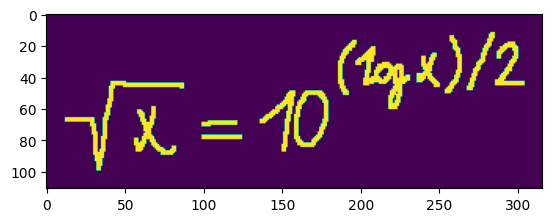

In [ ]:
from PIL import Image
image1 = Image.open("off_image_train/MfrDB1326_0.bmp")
plt.imshow(image1)

In [ ]:
from os.path import join
from PIL import Image
from torchvision import transforms
import torch

def preprocess(data_dir, split):
    assert split in ["train", "test"]

    print(f"Process {split} dataset...")
    images_dir = join(data_dir, f"off_image_{split}")

    captions_file = join(data_dir, f"{split}_caption.txt")
    pairs = []
    transform = transforms.ToTensor()
    with open(captions_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t', 1)
            if len(parts) == 2:
                img_name, formula = parts
                img_path = join(images_dir, img_name + '_0.bmp')

                img = Image.open(img_path).convert('RGB')
                img_tensor = transform(img)
                pair = (img_tensor, formula)
                pairs.append(pair)

    pairs.sort(key=lambda x: x[0].shape[1])  # Sorting based on image width

    out_file = join(data_dir, f"{split}.pkl")
    torch.save(pairs, out_file)
    print(f"Saved {split} dataset to {out_file}")

# data path
data_path = "./"

def img_size(pair):
    img, formula = pair
    return tuple(img.size())

splits = ["test", "train"]
for s in splits:
    preprocess(data_path, s)


Process test dataset...
Saved test dataset to ./test.pkl
Process train dataset...
Saved train dataset to ./train.pkl


##build vocab

In [ ]:
from os.path import join
import pickle as pkl
from collections import Counter
import argparse

START_TOKEN = 0
PAD_TOKEN = 1
END_TOKEN = 2
UNK_TOKEN = 3

class Vocab(object):
    def __init__(self):
        self.sign2id = {"<s>": START_TOKEN, "</s>": END_TOKEN,
                        "<pad>": PAD_TOKEN, "<unk>": UNK_TOKEN}
        self.id2sign = dict((idx, token) for token, idx in self.sign2id.items())
        self.length = 4

    def add_sign(self, sign):
        if sign not in self.sign2id:
            self.sign2id[sign] = self.length
            self.id2sign[self.length] = sign
            self.length += 1

    def __len__(self):
        return self.length

def build_vocab(data_dir, min_count=10):
    vocab = Vocab()
    counter = Counter()

    # our caption files
    caption_files = ['train_caption.txt', 'test_caption.txt']

    for caption_file in caption_files:
        with open(join(data_dir, caption_file), 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    _, formula = parts
                    formula_tokens = formula.split()
                    counter.update(formula_tokens)

    for word, count in counter.most_common():
        if count >= min_count:
            vocab.add_sign(word)

    vocab_file = join(data_dir, 'vocab.pkl')
    print("Writing Vocab File in ", vocab_file)
    with open(vocab_file, 'wb') as w:
        pkl.dump(vocab, w)

def load_vocab(data_dir):
    with open(join(data_dir, 'vocab.pkl'), 'rb') as f:
        vocab = pkl.load(f)
    print("Load vocab including {} words!".format(len(vocab)))
    return vocab

if __name__ == "__main__":
    data_path = "./"
    vocab = build_vocab(data_path)


Writing Vocab File in  ./vocab.pkl


##Helper Functions

In [ ]:
import os
import math

import torch
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli

def collate_fn(sign2id, batch):
    # filter the pictures that have different weight or height
    size = batch[0][0].size()
    batch = [img_formula for img_formula in batch
             if img_formula[0].size() == size]
    # sort by the length of formula
    batch.sort(key=lambda img_formula: len(img_formula[1].split()),
               reverse=True)

    imgs, formulas = zip(*batch)
    formulas = [formula.split() for formula in formulas]
    # targets for training , begin with START_TOKEN
    tgt4training = formulas2tensor(add_start_token(formulas), sign2id)
    # targets for calculating loss , end with END_TOKEN
    tgt4cal_loss = formulas2tensor(add_end_token(formulas), sign2id)
    imgs = torch.stack(imgs, dim=0)
    return imgs, tgt4training, tgt4cal_loss


def formulas2tensor(formulas, sign2id):
    """convert formula to tensor"""

    batch_size = len(formulas)
    max_len = len(formulas[0])
    tensors = torch.ones(batch_size, max_len, dtype=torch.long) * PAD_TOKEN
    for i, formula in enumerate(formulas):
        for j, sign in enumerate(formula):
            tensors[i][j] = sign2id.get(sign, UNK_TOKEN)
    return tensors


def add_start_token(formulas):
    return [['<s>']+formula for formula in formulas]


def add_end_token(formulas):
    return [formula+['</s>'] for formula in formulas]


def count_parameters(model):
    """count model parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def tile(x, count, dim=0):
    """
    Tiles x on dimension dim count times.
    """
    perm = list(range(len(x.size())))
    if dim != 0:
        perm[0], perm[dim] = perm[dim], perm[0]
        x = x.permute(perm).contiguous()
    out_size = list(x.size())
    out_size[0] *= count
    batch = x.size(0)
    x = x.view(batch, -1) \
         .transpose(0, 1) \
         .repeat(count, 1) \
         .transpose(0, 1) \
         .contiguous() \
         .view(*out_size)
    if dim != 0:
        x = x.permute(perm).contiguous()
    return x


def load_formulas(filename):
    formulas = dict()
    with open(filename) as f:
        for idx, line in enumerate(f):
            formulas[idx] = line.strip()
    print("Loaded {} formulas from {}".format(len(formulas), filename))
    return formulas


def cal_loss(logits, targets):
    """args:
        logits: probability distribution return by model
                [B, MAX_LEN, voc_size]
        targets: target formulas
                [B, MAX_LEN]
    """
    padding = torch.ones_like(targets) * PAD_TOKEN
    mask = (targets != padding)

    targets = targets.masked_select(mask)
    logits = logits.masked_select(
        mask.unsqueeze(2).expand(-1, -1, logits.size(2))
    ).contiguous().view(-1, logits.size(2))
    logits = torch.log(logits)

    assert logits.size(0) == targets.size(0)

    loss = F.nll_loss(logits, targets)
    return loss


def get_checkpoint(ckpt_dir):
    """return full path if there is ckpt in ckpt_dir else None"""
    if not os.path.isdir(ckpt_dir):
        raise FileNotFoundError("No checkpoint found in {}".format(ckpt_dir))

    ckpts = [f for f in os.listdir(ckpt_dir) if f.startswith('ckpt')]
    if not ckpts:
        raise FileNotFoundError("No checkpoint found in {}".format(ckpt_dir))

    last_ckpt, max_epoch = None, 0
    for ckpt in ckpts:
        epoch = int(ckpt.split('-')[1])
        if epoch > max_epoch:
            max_epoch = epoch
            last_ckpt = ckpt
    full_path = os.path.join(ckpt_dir, last_ckpt)
    print("Get checkpoint from {} for training".format(full_path))
    return full_path


def schedule_sample(prev_logit, prev_tgt, epsilon):
    prev_out = torch.argmax(prev_logit, dim=1, keepdim=True)
    prev_choices = torch.cat([prev_out, prev_tgt], dim=1)  # [B, 2]
    batch_size = prev_choices.size(0)
    prob = Bernoulli(torch.tensor([epsilon]*batch_size).unsqueeze(1))
    # sampling
    sample = prob.sample().long().to(prev_tgt.device)
    next_inp = torch.gather(prev_choices, 1, sample)
    return next_inp


def cal_epsilon(k, step, method):
    """
    Reference:
        Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
        See details in https://arxiv.org/pdf/1506.03099.pdf
    """
    assert method in ['inv_sigmoid', 'exp', 'teacher_forcing']

    if method == 'exp':
        return k**step
    elif method == 'inv_sigmoid':
        return k/(k+math.exp(step/k))
    else:
        return 1.

##Dataset Class

In [ ]:
from os.path import join

from torch.utils.data import Dataset
import torch

class Im2LatexDataset(Dataset):
    def __init__(self, data_dir, split, max_len):
        """
        Args:
        data_dir: root dir storing the preprocessed data
        split: 'train' or 'test'
        max_len: maximum length of the formula in tokens
        """
        assert split in ["train", "test"], "Invalid split name"
        self.data_dir = data_dir
        self.split = split
        self.max_len = max_len
        self.pairs = self._load_pairs()

    def _load_pairs(self):
        pairs = torch.load(join(self.data_dir, f"{self.split}.pkl"))
        # Processing formula to ensure it does not exceed max length
        for i, (img_tensor, formula) in enumerate(pairs):
            formula_tokens = formula.split()[:self.max_len]
            formula = " ".join(formula_tokens)  # Re-join tokens to string
            pairs[i] = (img_tensor, formula)
        return pairs

    def __getitem__(self, index):
        """Returns the item at the specified index in the dataset."""
        return self.pairs[index]

    def __len__(self):
        """Returns the total number of items in the dataset."""
        return len(self.pairs)

##Positional Embedding

In [ ]:
import math

import torch


def add_positional_features(tensor: torch.Tensor,
                            min_timescale: float = 1.0,
                            max_timescale: float = 1.0e4):
    """
    Implements the frequency-based positional encoding described
    in `Attention is all you Need

    Parameters
    ----------
    tensor : ``torch.Tensor``
        a Tensor with shape (batch_size, timesteps, hidden_dim).
    min_timescale : ``float``, optional (default = 1.0)
        The largest timescale to use.
    Returns
    -------
    The input tensor augmented with the sinusoidal frequencies.
    """
    _, timesteps, hidden_dim = tensor.size()

    timestep_range = get_range_vector(timesteps, tensor.device).data.float()
    # We're generating both cos and sin frequencies,
    # so half for each.
    num_timescales = hidden_dim // 2
    timescale_range = get_range_vector(
        num_timescales, tensor.device).data.float()

    log_timescale_increments = math.log(
        float(max_timescale) / float(min_timescale)) / float(num_timescales - 1)
    inverse_timescales = min_timescale * \
        torch.exp(timescale_range * -log_timescale_increments)

    # Broadcasted multiplication - shape (timesteps, num_timescales)
    scaled_time = timestep_range.unsqueeze(1) * inverse_timescales.unsqueeze(0)
    # shape (timesteps, 2 * num_timescales)
    sinusoids = torch.randn(
        scaled_time.size(0), 2*scaled_time.size(1), device=tensor.device)
    sinusoids[:, ::2] = torch.sin(scaled_time)
    sinusoids[:, 1::2] = torch.sin(scaled_time)
    if hidden_dim % 2 != 0:
        # if the number of dimensions is odd, the cos and sin
        # timescales had size (hidden_dim - 1) / 2, so we need
        # to add a row of zeros to make up the difference.
        sinusoids = torch.cat(
            [sinusoids, sinusoids.new_zeros(timesteps, 1)], 1)
    return tensor + sinusoids.unsqueeze(0)


def get_range_vector(size: int, device) -> torch.Tensor:
    return torch.arange(0, size, dtype=torch.long, device=device)

##Defining the model

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.distributions.uniform import Uniform

INIT = 1e-2


class Im2LatexModel(nn.Module):
    def __init__(self, out_size, emb_size, dec_rnn_h,
                 enc_out_dim=512,  n_layer=1,
                 add_pos_feat=False, dropout=0.):
        super(Im2LatexModel, self).__init__()

        self.cnn_encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 1),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1), 0),

            nn.Conv2d(256, enc_out_dim, 3, 1, 0),
            nn.ReLU()
        )

        self.rnn_decoder = nn.LSTMCell(dec_rnn_h+emb_size, dec_rnn_h)
        self.embedding = nn.Embedding(out_size, emb_size)

        self.init_wh = nn.Linear(enc_out_dim, dec_rnn_h)
        self.init_wc = nn.Linear(enc_out_dim, dec_rnn_h)
        self.init_wo = nn.Linear(enc_out_dim, dec_rnn_h)

        # Attention mechanism
        self.beta = nn.Parameter(torch.Tensor(enc_out_dim))
        init.uniform_(self.beta, -INIT, INIT)
        self.W_1 = nn.Linear(enc_out_dim, enc_out_dim, bias=False)
        self.W_2 = nn.Linear(dec_rnn_h, enc_out_dim, bias=False)

        self.W_3 = nn.Linear(dec_rnn_h+enc_out_dim, dec_rnn_h, bias=False)
        self.W_out = nn.Linear(dec_rnn_h, out_size, bias=False)

        self.add_pos_feat = add_pos_feat
        self.dropout = nn.Dropout(p=dropout)
        self.uniform = Uniform(0, 1)

    def forward(self, imgs, formulas, epsilon=1.):
        """args:
        imgs: [B, C, H, W]
        formulas: [B, MAX_LEN]
        epsilon: probability of the current time step to
                 use the true previous token
        return:
        logits: [B, MAX_LEN, VOCAB_SIZE]
        """
        # encoding
        encoded_imgs = self.encode(imgs)  # [B, H*W, 512]
        # init decoder's states
        dec_states, o_t = self.init_decoder(encoded_imgs)
        max_len = formulas.size(1)
        logits = []
        for t in range(max_len):
            tgt = formulas[:, t:t+1]
            # schedule sampling
            if logits and self.uniform.sample().item() > epsilon:
                tgt = torch.argmax(torch.log(logits[-1]), dim=1, keepdim=True)
            # ont step decoding
            dec_states, O_t, logit = self.step_decoding(
                dec_states, o_t, encoded_imgs, tgt)
            logits.append(logit)
        logits = torch.stack(logits, dim=1)  # [B, MAX_LEN, out_size]
        return logits

    def encode(self, imgs):
        encoded_imgs = self.cnn_encoder(imgs)  # [B, 512, H', W']
        encoded_imgs = encoded_imgs.permute(0, 2, 3, 1)  # [B, H', W', 512]
        B, H, W, _ = encoded_imgs.shape
        encoded_imgs = encoded_imgs.contiguous().view(B, H*W, -1)
        if self.add_pos_feat:
            encoded_imgs = add_positional_features(encoded_imgs)
        return encoded_imgs

    def step_decoding(self, dec_states, o_t, enc_out, tgt):
        """Runing one step decoding"""

        prev_y = self.embedding(tgt).squeeze(1)  # [B, emb_size]
        inp = torch.cat([prev_y, o_t], dim=1)  # [B, emb_size+dec_rnn_h]
        h_t, c_t = self.rnn_decoder(inp, dec_states)  # h_t:[B, dec_rnn_h]
        h_t = self.dropout(h_t)
        c_t = self.dropout(c_t)

        # context_t : [B, C]
        context_t, attn_scores = self._get_attn(enc_out, h_t)

        # [B, dec_rnn_h]
        o_t = self.W_3(torch.cat([h_t, context_t], dim=1)).tanh()
        o_t = self.dropout(o_t)

        # calculate logit
        logit = F.softmax(self.W_out(o_t), dim=1)  # [B, out_size]

        return (h_t, c_t), o_t, logit

    def _get_attn(self, enc_out, h_t):
        """Attention mechanism
        args:
            enc_out: row encoder's output [B, L=H*W, C]
            h_t: the current time step hidden state [B, dec_rnn_h]
        return:
            context: this time step context [B, C]
            attn_scores: Attention scores
        """
        # cal alpha
        alpha = torch.tanh(self.W_1(enc_out)+self.W_2(h_t).unsqueeze(1))
        alpha = torch.sum(self.beta*alpha, dim=-1)  # [B, L]
        alpha = F.softmax(alpha, dim=-1)  # [B, L]

        # cal context: [B, C]
        context = torch.bmm(alpha.unsqueeze(1), enc_out)
        context = context.squeeze(1)
        return context, alpha

    def init_decoder(self, enc_out):
        """args:
            enc_out: the output of row encoder [B, H*W, C]
          return:
            h_0, c_0:  h_0 and c_0's shape: [B, dec_rnn_h]
            init_O : the average of enc_out  [B, dec_rnn_h]
            for decoder
        """
        mean_enc_out = enc_out.mean(dim=1)
        h = self._init_h(mean_enc_out)
        c = self._init_c(mean_enc_out)
        init_o = self._init_o(mean_enc_out)
        return (h, c), init_o

    def _init_h(self, mean_enc_out):
        return torch.tanh(self.init_wh(mean_enc_out))

    def _init_c(self, mean_enc_out):
        return torch.tanh(self.init_wc(mean_enc_out))

    def _init_o(self, mean_enc_out):
        return torch.tanh(self.init_wo(mean_enc_out))

##Beam search for decoder

In [ ]:
import torch

"""
Borrow from https://github.com/allenai/allennlp/blob/master/allennlp/nn/beam_search.py
"""

class BeamSearch:
    """
    Implements the beam search algorithm for decoding the most likely sequences.

    Parameters
    ----------
    end_index : ``int``
        The index of the "stop" or "end" token in the target vocabulary.
    max_steps : ``int``, optional (default = 50)
        The maximum number of decoding steps to take, i.e. the maximum length
        of the predicted sequences.
    beam_size : ``int``, optional (default = 10)
        The width of the beam used.
    per_node_beam_size : ``int``, optional (default = beam_size)
        The maximum number of candidates to consider per node, at each step in the search.
        If not given, this just defaults to ``beam_size``. Setting this parameter
        to a number smaller than ``beam_size`` may give better results,
        as it can introduce more diversity into the search.
        See `Beam Search Strategies for Neural Machine Translation.
        Freitag and Al-Onaizan, 2017 <http://arxiv.org/abs/1702.01806>`_.
    """

    def __init__(self,
                 end_index: int,
                 max_steps: int = 50,
                 beam_size: int = 10,
                 per_node_beam_size: int = None) -> None:
        self._end_index = end_index
        self.max_steps = max_steps
        self.beam_size = beam_size
        self.per_node_beam_size = per_node_beam_size or beam_size

    def search(self, start_predictions, start_state, step):
        """
        Given a starting state and a step function, apply beam search to find the
        most likely target sequences.

        Notes
        -----
        If your step function returns ``-inf`` for some log probabilities
        (like if you're using a masked log-softmax) then some of the "best"
        sequences returned may also have ``-inf`` log probability. Specifically
        this happens when the beam size is smaller than the number of actions
        with finite log probability (non-zero probability) returned by the step function.
        Therefore if you're using a mask you may want to check the results from ``search``
        and potentially discard sequences with non-finite log probability.

        Parameters
        ----------
        start_predictions : ``torch.Tensor``
            A tensor containing the initial predictions with shape ``(batch_size,)``.
            Usually the initial predictions are just the index of the "start" token
            in the target vocabulary.
        start_state : ``dict``
            The initial state passed to the ``step`` function.
            Each value of the state dict should be a tensor of shape ``(batch_size, *)``,
            where ``*`` means any other number of dimensions.
        step : ``function``
            A function that is responsible for computing the next most likely tokens,
            given the current state and the predictions from the last time step.
            The function should accept two arguments. The first being a tensor
            of shape ``(group_size,)``, representing the index of the predicted
            tokens from the last time step, and the second being the current state.
            The ``group_size`` will be ``batch_size * beam_size``, except in the initial
            step, for which it will just be ``batch_size``.
            The function is expected to return a tuple, where the first element
            is a tensor of shape ``(group_size, target_vocab_size)`` containing
            the log probabilities of the tokens for the next step, and the second
            element is the updated state. The tensor in the state should have shape
            ``(group_size, *)``, where ``*`` means any other number of dimensions.

        Returns
        -------
        Tuple[torch.Tensor, torch.Tensor]
            Tuple of ``(predictions, log_probabilities)``, where ``predictions``
            has shape ``(batch_size, beam_size, max_steps)`` and ``log_probabilities``
            has shape ``(batch_size, beam_size)``.
        """
        batch_size = start_predictions.size()[0]

        # List of (batch_size, beam_size) tensors. One for each time step. Does not
        # include the start symbols, which are implicit.
        predictions = []

        # List of (batch_size, beam_size) tensors. One for each time step. None for
        # the first.  Stores the index n for the parent prediction, i.e.
        # predictions[t-1][i][n], that it came from.
        backpointers = []

        # Calculate the first timestep. This is done outside the main loop
        # because we are going from a single decoder input (the output from the
        # encoder) to the top `beam_size` decoder outputs. On the other hand,
        # within the main loop we are going from the `beam_size` elements of the
        # beam to `beam_size`^2 candidates from which we will select the top
        # `beam_size` elements for the next iteration.
        # shape: (batch_size, num_classes)
        start_class_log_probabilities, state = step(
            start_predictions, start_state)

        num_classes = start_class_log_probabilities.size()[1]

        # shape: (batch_size, beam_size), (batch_size, beam_size)
        start_top_log_probabilities, start_predicted_classes = \
            start_class_log_probabilities.topk(self.beam_size)
        if self.beam_size == 1 and (start_predicted_classes == self._end_index).all():
            print("Empty sequences predicted. You may want to "
                  "increase the beam size or ensure "
                  "your step function is working properly.")
            return start_predicted_classes.unsqueeze(-1), start_top_log_probabilities

        # The log probabilities for the last time step.
        # shape: (batch_size, beam_size)
        last_log_probabilities = start_top_log_probabilities

        # shape: [(batch_size, beam_size)]
        predictions.append(start_predicted_classes)

        # Log probability tensor that mandates that the end token is selected.
        # shape: (batch_size * beam_size, num_classes)
        log_probs_after_end = start_class_log_probabilities.new_full(
            (batch_size * self.beam_size, num_classes),
            float("-inf")
        )
        log_probs_after_end[:, self._end_index] = 0.

        # Set the same state for each element in the beam.
        for key, state_tensor in state.items():
            _, *last_dims = state_tensor.size()
            # shape: (batch_size * beam_size, *)
            state[key] = state_tensor.\
                unsqueeze(1).\
                expand(batch_size, self.beam_size, *last_dims).\
                reshape(batch_size * self.beam_size, *last_dims)

        for timestep in range(self.max_steps - 1):
            # shape: (batch_size * beam_size,)
            last_predictions = predictions[-1].reshape(
                batch_size * self.beam_size)

            # If every predicted token from the last step is `self._end_index`,
            # then we can stop early.
            if (last_predictions == self._end_index).all():
                break

            # Take a step. This get the predicted log probs of the next classes
            # and updates the state.
            # shape: (batch_size * beam_size, num_classes)
            class_log_probabilities, state = step(last_predictions, state)

            # shape: (batch_size * beam_size, num_classes)
            last_predictions_expanded = last_predictions.unsqueeze(-1).expand(
                batch_size * self.beam_size,
                num_classes
            )

            # Here we are finding any beams where we predicted the end token in
            # the previous timestep and replacing the distribution with a
            # one-hot distribution, forcing the beam to predict the end token
            # this timestep as well.
            # shape: (batch_size * beam_size, num_classes)
            cleaned_log_probabilities = torch.where(
                last_predictions_expanded == self._end_index,
                log_probs_after_end,
                class_log_probabilities
            )

            # shape (both): (batch_size * beam_size, per_node_beam_size)
            top_log_probabilities, predicted_classes = \
                cleaned_log_probabilities.topk(self.per_node_beam_size)

            # Here we expand the last log probabilities to (batch_size * beam_size, per_node_beam_size)
            # so that we can add them to the current log probs for this timestep.
            # This lets us maintain the log probability of each element on the beam.
            # shape: (batch_size * beam_size, per_node_beam_size)
            expanded_last_log_probabilities = last_log_probabilities.\
                unsqueeze(2).\
                expand(batch_size, self.beam_size, self.per_node_beam_size).\
                reshape(batch_size * self.beam_size, self.per_node_beam_size)

            # shape: (batch_size * beam_size, per_node_beam_size)
            summed_top_log_probabilities = top_log_probabilities + \
                expanded_last_log_probabilities

            # shape: (batch_size, beam_size * per_node_beam_size)
            reshaped_summed = summed_top_log_probabilities.\
                reshape(batch_size, self.beam_size * self.per_node_beam_size)

            # shape: (batch_size, beam_size * per_node_beam_size)
            reshaped_predicted_classes = predicted_classes.\
                reshape(batch_size, self.beam_size * self.per_node_beam_size)

            # Keep only the top `beam_size` beam indices.
            # shape: (batch_size, beam_size), (batch_size, beam_size)
            restricted_beam_log_probs, restricted_beam_indices = reshaped_summed.topk(
                self.beam_size)

            # Use the beam indices to extract the corresponding classes.
            # shape: (batch_size, beam_size)
            restricted_predicted_classes = reshaped_predicted_classes.gather(
                1, restricted_beam_indices)

            predictions.append(restricted_predicted_classes)

            # shape: (batch_size, beam_size)
            last_log_probabilities = restricted_beam_log_probs

            # The beam indices come from a `beam_size * per_node_beam_size` dimension where the
            # indices with a common ancestor are grouped together. Hence
            # dividing by per_node_beam_size gives the ancestor. (Note that this is integer
            # division as the tensor is a LongTensor.)
            # shape: (batch_size, beam_size)
            backpointer = (restricted_beam_indices / self.per_node_beam_size).long()

            backpointers.append(backpointer)

            # Keep only the pieces of the state tensors corresponding to the
            # ancestors created this iteration.
            for key, state_tensor in state.items():
                _, *last_dims = state_tensor.size()
                # shape: (batch_size, beam_size, *)
                expanded_backpointer = backpointer.\
                    view(batch_size, self.beam_size, *([1] * len(last_dims))).\
                    expand(batch_size, self.beam_size, *last_dims)

                # shape: (batch_size * beam_size, *)
                state[key] = state_tensor.\
                    reshape(batch_size, self.beam_size, *last_dims).\
                    gather(1, expanded_backpointer).\
                    reshape(batch_size * self.beam_size, *last_dims)

        if not torch.isfinite(last_log_probabilities).all():
            print("Infinite log probabilities encountered. "
                  "Some final sequences may not make sense. "
                  "This can happen when the beam size is "
                  "larger than the number of valid (non-zero "
                  "probability) transitions that the step function produces.")

        # Reconstruct the sequences.
        # shape: [(batch_size, beam_size, 1)]
        reconstructed_predictions = [predictions[-1].unsqueeze(2)]

        # shape: (batch_size, beam_size)
        cur_backpointers = backpointers[-1]

        for timestep in range(len(predictions) - 2, 0, -1):
            # shape: (batch_size, beam_size, 1)
            cur_preds = predictions[timestep].gather(
                1, cur_backpointers).unsqueeze(2)

            reconstructed_predictions.append(cur_preds)

            # shape: (batch_size, beam_size)
            cur_backpointers = backpointers[timestep -
                                            1].gather(1, cur_backpointers)

        # shape: (batch_size, beam_size, 1)
        final_preds = predictions[0].gather(1, cur_backpointers).unsqueeze(2)

        reconstructed_predictions.append(final_preds)

        # shape: (batch_size, beam_size, max_steps)
        all_predictions = torch.cat(
            list(reversed(reconstructed_predictions)), 2)

        return all_predictions, last_log_probabilities

##Decoder

In [ ]:
import torch



class LatexProducer(object):
    """
    Model wrapper, implementing batch greedy decoding and
    batch beam search decoding
    """

    def __init__(self, model, vocab, beam_size=5, max_len=64, use_cuda=True):
        """args:
            the path to model checkpoint
        """
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.model = model.to(self.device)
        self._sign2id = vocab.sign2id
        self._id2sign = vocab.id2sign
        self.max_len = max_len
        self.beam_size = beam_size
        self._beam_search = BeamSearch(END_TOKEN, max_len, beam_size)

    def __call__(self, imgs):
        """args:
            imgs: images need to be decoded
            beam_size: if equal to 1, use greedy decoding
           returns:
            formulas list of batch_size length
        """
        if self.beam_size == 1:
            results = self._greedy_decoding(imgs)
        else:
            results = self._batch_beam_search(imgs)
        return results

    def _greedy_decoding(self, imgs):
        imgs = imgs.to(self.device)
        self.model.eval()

        enc_outs = self.model.encode(imgs)
        dec_states, O_t = self.model.init_decoder(enc_outs)

        batch_size = imgs.size(0)
        # storing decoding results
        formulas_idx = torch.ones(
            batch_size, self.max_len, device=self.device).long() * PAD_TOKEN
        # first decoding step's input
        tgt = torch.ones(
            batch_size, 1, device=self.device).long() * START_TOKEN
        with torch.no_grad():
            for t in range(self.max_len):
                dec_states, O_t, logit = self.model.step_decoding(
                    dec_states, O_t, enc_outs, tgt)

                tgt = torch.argmax(logit, dim=1, keepdim=True)
                formulas_idx[:, t:t + 1] = tgt
        results = self._idx2formulas(formulas_idx)
        return results

    def _simple_beam_search_decoding(self, imgs):
        """simpple beam search decoding (not support batch)"""
        self.model.eval()
        beam_results = [
            self._bs_decoding(img.unsqueeze(0))
            for img in imgs
        ]
        return beam_results

    def _idx2formulas(self, formulas_idx):
        """convert formula id matrix to formulas list"""
        results = []
        for id_ in formulas_idx:
            id_list = id_.tolist()
            result = []
            for sign_id in id_list:
                if sign_id != END_TOKEN:
                    result.append(self._id2sign[sign_id])
                else:
                    break
            results.append(" ".join(result))
        return results

    def _bs_decoding(self, img):
        """
        beam search decoding not support batch
        args:
            img: [1, C, H, W]
            beam_size: int
        return:
            formulas in str format
        """
        self.model.eval()
        img = img.to(self.device)

        # encoding
        # img = img.unsqueeze(0)  # [1, C, H, W]
        enc_outs = self.model.encode(img)  # [1, H*W, OUT_C]

        # prepare data for decoding
        enc_outs = enc_outs.expand(self.beam_size, -1, -1)
        # [Beam_size, dec_rnn_h]
        dec_states, O_t = self.model.init_decoder(enc_outs)

        # store top k ids (k is less or equal to beam_size)
        # in first decoding step, all they are  start token
        topk_ids = torch.ones(
            self.beam_size, device=self.device).long() * START_TOKEN
        topk_log_probs = torch.Tensor([0.0] + [-1e10] * (self.beam_size - 1))
        topk_log_probs = topk_log_probs.to(self.device)
        seqs = torch.ones(
            self.beam_size, 1, device=self.device).long() * START_TOKEN
        # store complete sequences and corrosponing scores
        complete_seqs = []
        complete_seqs_scores = []
        k = self.beam_size
        vocab_size = len(self._sign2id)
        with torch.no_grad():
            for t in range(self.max_len):
                dec_states, O_t, logit = self.model.step_decoding(
                    dec_states, O_t, enc_outs, topk_ids.unsqueeze(1))
                log_probs = torch.log(logit)  # [k, vocab_size]

                log_probs += topk_log_probs.unsqueeze(1)
                topk_log_probs, topk_ids = torch.topk(log_probs.view(-1), k)

                beam_index = topk_ids // vocab_size
                topk_ids = topk_ids % vocab_size

                seqs = torch.cat(
                    [seqs.index_select(0, beam_index), topk_ids.unsqueeze(1)],
                    dim=1
                )

                complete_inds = [
                    ind for ind, next_word in enumerate(topk_ids)
                    if next_word == END_TOKEN
                ]
                if t == (self.max_len-1):  # last_step, end all seqs
                    complete_inds = list(range(len(topk_ids)))

                incomplete_inds = list(
                    set(range(len(topk_ids))) - set(complete_inds)
                )
                if len(complete_inds) > 0:
                    complete_seqs.extend(seqs[complete_inds])
                    complete_seqs_scores.extend(topk_log_probs[complete_inds])
                k -= len(complete_inds)
                if k == 0:  # all beam finished
                    break

                # prepare for next step
                seqs = seqs[incomplete_inds]
                topk_ids = topk_ids[incomplete_inds]
                topk_log_probs = topk_log_probs[incomplete_inds]

                enc_outs = enc_outs[:k]
                seleted = beam_index[incomplete_inds]
                O_t = O_t[seleted]
                dec_states = (dec_states[0][seleted],
                              dec_states[1][seleted])

        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i][1:]
        result = self._idx2formulas(seq.unsqueeze(0))[0]
        return result

    def _batch_beam_search(self, imgs):
        self.model.eval()
        imgs = imgs.to(self.device)
        enc_outs = self.model.encode(imgs)  # [batch_size, H*W, OUT_C]
        # enc_outs = enc_outs.expand(self.beam_size, -1, -1)
        dec_states, O_t = self.model.init_decoder(enc_outs)

        batch_size = imgs.size(0)
        start_predictions = torch.ones(
            batch_size, device=self.device).long() * START_TOKEN
        state = {}
        state['h_t'] = dec_states[0]
        state['c_t'] = dec_states[1]
        state['o_t'] = O_t
        state['enc_outs'] = enc_outs
        all_top_k_predictions, log_probabilities = self._beam_search.search(
            start_predictions, state, self._take_step)

        all_top_predictions = all_top_k_predictions[:, 0, :]
        all_top_predictions = self._idx2formulas(all_top_predictions)
        return all_top_predictions

    def _take_step(self, last_predictions, state):
        dec_states = (state['h_t'], state['c_t'])
        O_t = state['o_t']
        enc_outs = state['enc_outs']

        last_predictions = last_predictions.unsqueeze(1)
        with torch.no_grad():
            dec_states, O_t, logit = self.model.step_decoding(
                dec_states, O_t, enc_outs, last_predictions)

        # update state
        state['h_t'] = dec_states[0]
        state['c_t'] = dec_states[1]
        state['o_t'] = O_t

        return (torch.log(logit), state)

##Trainer

In [ ]:
import os
from os.path import join
import matplotlib.pyplot as plt

import torch
from torch.nn.utils import clip_grad_norm_

class Trainer(object):
    def __init__(self, optimizer, model, lr_scheduler,
                 train_loader, val_loader, args,
                 use_cuda=True, init_epoch=1, last_epoch=15):

        self.optimizer = optimizer
        self.model = model
        self.lr_scheduler = lr_scheduler
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.args = args

        self.step = 0
        self.epoch = init_epoch
        self.total_step = (init_epoch-1)*len(train_loader)
        self.last_epoch = last_epoch
        self.best_val_loss = 1e18
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.train_losses = []  # List to store training losses per epoch
        self.val_losses = []  # List to store validation losses per epoch

    def train(self):
        mes = "Epoch {}, step:{}/{} {:.2f}%, Loss:{:.4f}, Perplexity:{:.4f}"

        while self.epoch <= self.last_epoch:
            self.model.train()
            losses = 0.0
            for imgs, tgt4training, tgt4cal_loss in self.train_loader:
                step_loss = self.train_step(imgs, tgt4training, tgt4cal_loss)
                losses += step_loss

                # log message
                if self.step % self.args['print_freq'] == 0:
                    avg_loss = losses / self.args['print_freq']
                    print(mes.format(
                        self.epoch, self.step, len(self.train_loader),
                        100 * self.step / len(self.train_loader),
                        avg_loss,
                        2**avg_loss
                    ))
                    losses = 0.0

            # added to track with train loss
            avg_epoch_loss = losses / len(self.train_loader)
            self.train_losses.append(avg_epoch_loss)

            # one epoch Finished, calcute val loss
            val_loss = self.validate()
            self.lr_scheduler.step(val_loss)

            #added to track val loss
            self.val_losses.append(val_loss.cpu().item())

            self.save_model('ckpt-{}-{:.4f}'.format(self.epoch, val_loss))
            self.epoch += 1
            self.step = 0

        #plot the train-val graph
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Training and Validation Losses')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        return self.train_losses, self.val_losses

    def train_step(self, imgs, tgt4training, tgt4cal_loss):
        self.optimizer.zero_grad()

        imgs = imgs.to(self.device)
        tgt4training = tgt4training.to(self.device)
        tgt4cal_loss = tgt4cal_loss.to(self.device)
        epsilon = cal_epsilon(
            self.args['decay_k'], self.total_step, self.args['sample_method'])
        logits = self.model(imgs, tgt4training, epsilon)

        # calculate loss
        loss = cal_loss(logits, tgt4cal_loss)
        self.step += 1
        self.total_step += 1
        loss.backward()
        clip_grad_norm_(self.model.parameters(), self.args['clip'])
        self.optimizer.step()

        return loss.item()

    def validate(self):
        self.model.eval()
        val_total_loss = 0.0
        predictions = []  # To store predictions
        mes = "Epoch {}, validation average loss:{:.4f}, Perplexity:{:.4f}"

        with torch.no_grad():
            for imgs, tgt4training, tgt4cal_loss in self.val_loader:
                imgs = imgs.to(self.device)
                tgt4training = tgt4training.to(self.device)
                tgt4cal_loss = tgt4cal_loss.to(self.device)

                epsilon = cal_epsilon(
                    self.args['decay_k'], self.total_step, self.args['sample_method'])
                logits = self.model(imgs, tgt4training, epsilon)
                loss = cal_loss(logits, tgt4cal_loss)
                val_total_loss += loss

                # Optionally, collect predictions here
                predictions.append(logits.cpu().numpy())  # or logits.detach().cpu().tolist()

            avg_loss = val_total_loss / len(self.val_loader)
            print(mes.format(
                self.epoch, avg_loss, 2**avg_loss
            ))
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.save_model('best_ckpt'+ str(self.args['model_number']))
        return avg_loss


    def save_model(self, model_name):
        if not os.path.isdir(self.args['save_dir']):
            os.makedirs(self.args['save_dir'])
        save_path = join(self.args['save_dir'], model_name+'.pt')
        print("Saving checkpoint to {}".format(save_path))

        # torch.save(self.model, model_path)

        torch.save({
            'epoch': self.epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'lr_sche': self.lr_scheduler.state_dict(),
            'epoch': self.epoch,
            'args': self.args
        }, save_path)

##evaluation metrices

In [ ]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=b09dc6f5a5f047399e8ba4d1bf5fe199b6b5deda2bd6e8cda133992b6e69b03d
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [ ]:
import numpy as np
import nltk
import distance

def score_files(path_ref, path_hyp):
    """Loads result from file and score it

    Args:
        path_ref: (string) formulas of reference
        path_hyp: (string) formulas of prediction.

    Returns:
        scores: (dict)

    """
    # load formulas
    formulas_ref = load_formulas(path_ref)
    formulas_hyp = load_formulas(path_hyp)

    assert len(formulas_ref) == len(formulas_hyp)

    # tokenize
    refs = [ref.split(' ') for _, ref in formulas_ref.items()]
    hyps = [hyp.split(' ') for _, hyp in formulas_hyp.items()]

    # score
    return {
        "BLEU-4": bleu_score(refs, hyps)*100,
        "EM": exact_match_score(refs, hyps)*100,
        "Edit": edit_distance(refs, hyps)*100,
        "Partial Match": partial_match_score(refs, hyps)
    }


def exact_match_score(references, hypotheses):
    """Computes exact match scores.

    Args:
        references: list of list of tokens (one ref)
        hypotheses: list of list of tokens (one hypothesis)

    Returns:
        exact_match: (float) 1 is perfect

    """
    exact_match = 0
    for ref, hypo in zip(references, hypotheses):
        if np.array_equal(ref, hypo):
            exact_match += 1

    return exact_match / float(max(len(hypotheses), 1))


def bleu_score(references, hypotheses):
    """Computes bleu score.

    Args:
        references: list of list (one hypothesis)
        hypotheses: list of list (one hypothesis)

    Returns:
        BLEU-4 score: (float)

    """
    references = [[ref] for ref in references]  # for corpus_bleu func
    BLEU_4 = nltk.translate.bleu_score.corpus_bleu(
        references, hypotheses,
        weights=(0.25, 0.25, 0.25, 0.25)
    )
    return BLEU_4


def edit_distance(references, hypotheses):
    """Computes Levenshtein distance between two sequences.

    Args:
        references: list of list of token (one hypothesis)
        hypotheses: list of list of token (one hypothesis)

    Returns:
        1 - levenshtein distance: (higher is better, 1 is perfect)

    """
    d_leven, len_tot = 0, 0
    for ref, hypo in zip(references, hypotheses):
        d_leven += distance.levenshtein(ref, hypo)
        len_tot += float(max(len(ref), len(hypo)))

    return 1. - d_leven / len_tot

def partial_match_score(references, hypotheses):
    """Computes partial match scores, evaluating token overlap regardless of order.

    Args:
        references: list of list of tokens (one ref)
        hypotheses: list of list of tokens (one hypothesis)

    Returns:
        partial_match: (float) percentage of hypotheses tokens that are found in the references
    """
    partial_matches = 0
    total_tokens = 0
    for ref, hypo in zip(references, hypotheses):
        ref_set = set(ref)
        matched_tokens = sum(token in ref_set for token in hypo)
        total_tokens += len(hypo)
        partial_matches += matched_tokens

    if total_tokens == 0:
        return 0  # Avoid division by zero
    return partial_matches / total_tokens * 100  # Convert to percentage


##start training the model

In [ ]:
import random
from itertools import product

search_space = {
    "emb_dim": [50, 80, 100],
    "dec_rnn_h": [256, 512, 1024],
    "add_position_features": [True, False],
    "dropout": [0.0, 0.1, 0.2],
    "lr": [5e-3,1e-3,5e-4,1e-4],
    "lr_decay": [0.1, 0.5, 0.9],
    "lr_patience": [2, 3, 4],
    "clip": [1.0, 2.0, 3.0]
}

In [ ]:
sampled_hyperparameters = {param: random.choice(values) for param, values in search_space.items()}
sampled_hyperparameters

{'emb_dim': 50,
 'dec_rnn_h': 1024,
 'add_position_features': True,
 'dropout': 0.1,
 'lr': 0.0001,
 'decay_k': 0.5,
 'lr_decay': 0.7,
 'lr_patience': 2,
 'clip': 2.0}

Load vocab including 113 words!
start training for model  0 , hyper-parameters:  {'emb_dim': 50, 'dec_rnn_h': 512, 'add_position_features': False, 'dropout': 0.0, 'lr': 0.0001, 'lr_decay': 0.9, 'lr_patience': 2, 'clip': 1.0, 'model_number': 0}


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, step:100/553 18.08%, Loss:4.0613, Perplexity:16.6942
Epoch 1, step:200/553 36.17%, Loss:3.8231, Perplexity:14.1532
Epoch 1, step:300/553 54.25%, Loss:3.6331, Perplexity:12.4075
Epoch 1, step:400/553 72.33%, Loss:3.3477, Perplexity:10.1806
Epoch 1, step:500/553 90.42%, Loss:2.8980, Perplexity:7.4541
Epoch 1, validation average loss:3.6646, Perplexity:12.6813
Saving checkpoint to ./best_ckpt0.pt
Saving checkpoint to ./ckpt-1-3.6646.pt
Epoch 2, step:100/553 18.08%, Loss:3.7532, Perplexity:13.4841
Epoch 2, step:200/553 36.17%, Loss:3.3082, Perplexity:9.9054
Epoch 2, step:300/553 54.25%, Loss:2.9953, Perplexity:7.9738
Epoch 2, step:400/553 72.33%, Loss:2.6160, Perplexity:6.1305
Epoch 2, step:500/553 90.42%, Loss:2.4844, Perplexity:5.5958
Epoch 2, validation average loss:3.3493, Perplexity:10.1913
Saving checkpoint to ./best_ckpt0.pt
Saving checkpoint to ./ckpt-2-3.3493.pt
Epoch 3, step:100/553 18.08%, Loss:3.5691, Perplexity:11.8691
Epoch 3, step:200/553 36.17%, Loss:3.1130, Perple

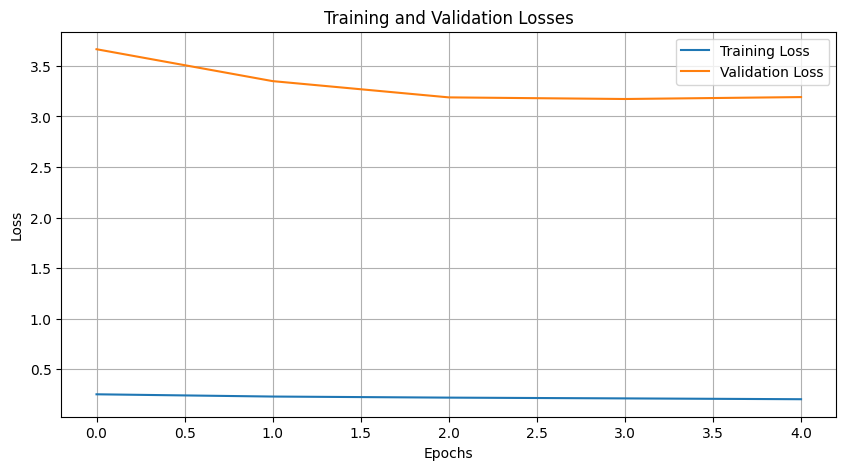

start training for model  1 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 1024, 'add_position_features': True, 'dropout': 0.0, 'lr': 0.0001, 'lr_decay': 0.5, 'lr_patience': 3, 'clip': 2.0, 'model_number': 1}
Epoch 1, step:100/553 18.08%, Loss:3.8019, Perplexity:13.9470
Epoch 1, step:200/553 36.17%, Loss:3.7127, Perplexity:13.1113
Epoch 1, step:300/553 54.25%, Loss:3.4196, Perplexity:10.7002
Epoch 1, step:400/553 72.33%, Loss:2.7977, Perplexity:6.9535
Epoch 1, step:500/553 90.42%, Loss:2.4914, Perplexity:5.6231
Epoch 1, validation average loss:3.1210, Perplexity:8.7001
Saving checkpoint to ./best_ckpt1.pt
Saving checkpoint to ./ckpt-1-3.1210.pt
Epoch 2, step:100/553 18.08%, Loss:3.1003, Perplexity:8.5758
Epoch 2, step:200/553 36.17%, Loss:2.9903, Perplexity:7.9466
Epoch 2, step:300/553 54.25%, Loss:2.6686, Perplexity:6.3580
Epoch 2, step:400/553 72.33%, Loss:2.3320, Perplexity:5.0352
Epoch 2, step:500/553 90.42%, Loss:2.1917, Perplexity:4.5686
Epoch 2, validation average loss:3.0226

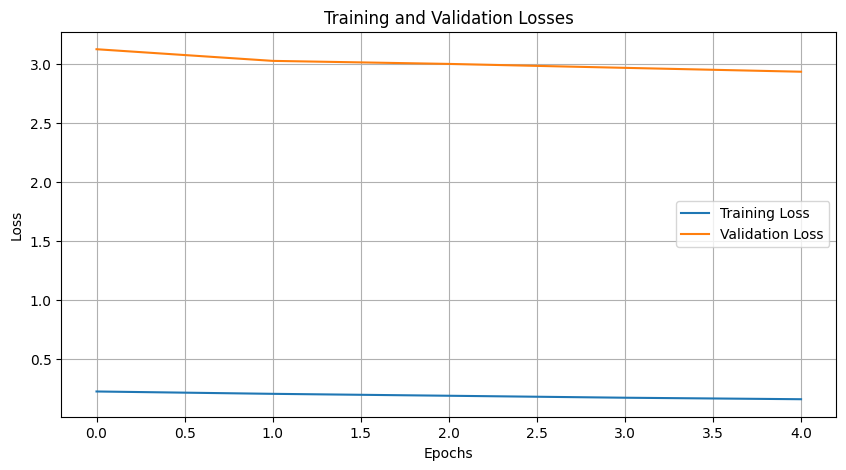

start training for model  2 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 1024, 'add_position_features': False, 'dropout': 0.1, 'lr': 0.0001, 'lr_decay': 0.1, 'lr_patience': 2, 'clip': 3.0, 'model_number': 2}
Epoch 1, step:100/553 18.08%, Loss:3.9645, Perplexity:15.6109
Epoch 1, step:200/553 36.17%, Loss:3.7991, Perplexity:13.9205
Epoch 1, step:300/553 54.25%, Loss:3.4985, Perplexity:11.3017
Epoch 1, step:400/553 72.33%, Loss:2.8743, Perplexity:7.3325
Epoch 1, step:500/553 90.42%, Loss:2.5799, Perplexity:5.9790
Epoch 1, validation average loss:3.7697, Perplexity:13.6395
Saving checkpoint to ./best_ckpt2.pt
Saving checkpoint to ./ckpt-1-3.7697.pt
Epoch 2, step:100/553 18.08%, Loss:3.5758, Perplexity:11.9241
Epoch 2, step:200/553 36.17%, Loss:3.1257, Perplexity:8.7281
Epoch 2, step:300/553 54.25%, Loss:2.8035, Perplexity:6.9814
Epoch 2, step:400/553 72.33%, Loss:2.4487, Perplexity:5.4594
Epoch 2, step:500/553 90.42%, Loss:2.3029, Perplexity:4.9343
Epoch 2, validation average loss:3.2

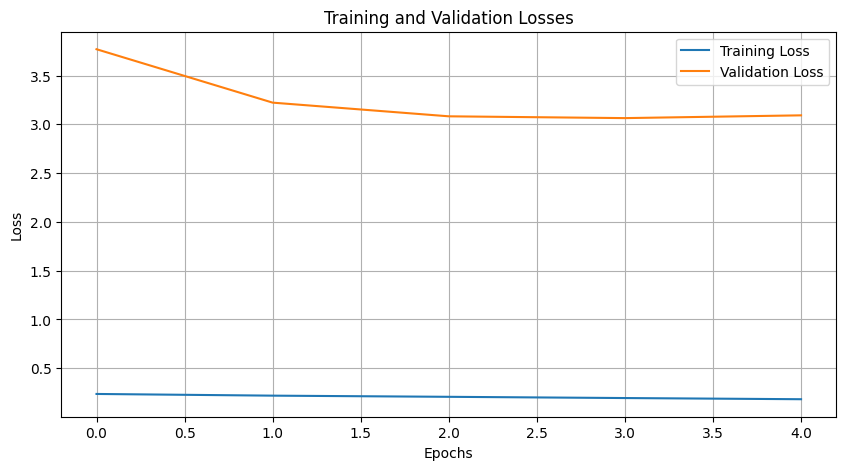

start training for model  3 , hyper-parameters:  {'emb_dim': 100, 'dec_rnn_h': 256, 'add_position_features': False, 'dropout': 0.1, 'lr': 0.001, 'lr_decay': 0.1, 'lr_patience': 2, 'clip': 2.0, 'model_number': 3}
Epoch 1, step:100/553 18.08%, Loss:4.3789, Perplexity:20.8059
Epoch 1, step:200/553 36.17%, Loss:4.0923, Perplexity:17.0567
Epoch 1, step:300/553 54.25%, Loss:3.8833, Perplexity:14.7567
Epoch 1, step:400/553 72.33%, Loss:3.6072, Perplexity:12.1862
Epoch 1, step:500/553 90.42%, Loss:3.4541, Perplexity:10.9597
Epoch 1, validation average loss:4.2461, Perplexity:18.9754
Saving checkpoint to ./best_ckpt3.pt
Saving checkpoint to ./ckpt-1-4.2461.pt
Epoch 2, step:100/553 18.08%, Loss:4.1991, Perplexity:18.3679
Epoch 2, step:200/553 36.17%, Loss:4.0066, Perplexity:16.0730
Epoch 2, step:300/553 54.25%, Loss:3.8570, Perplexity:14.4903
Epoch 2, step:400/553 72.33%, Loss:3.5995, Perplexity:12.1212
Epoch 2, step:500/553 90.42%, Loss:3.4429, Perplexity:10.8750
Epoch 2, validation average los

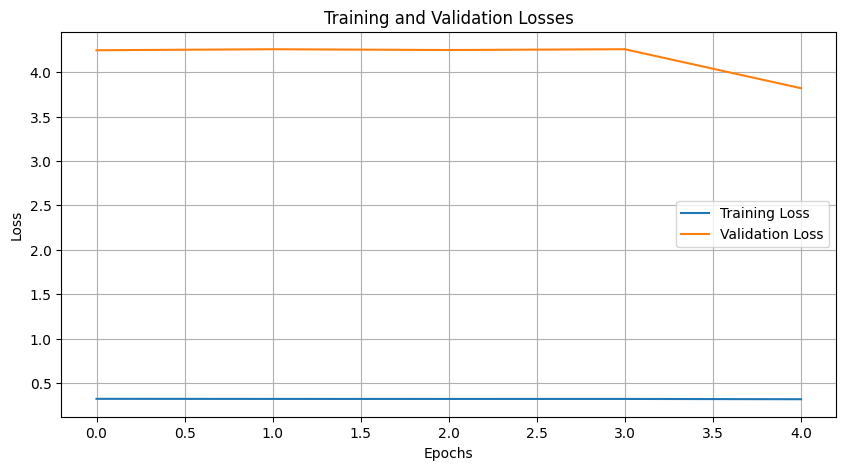

start training for model  4 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 512, 'add_position_features': False, 'dropout': 0.0, 'lr': 0.001, 'lr_decay': 0.1, 'lr_patience': 4, 'clip': 1.0, 'model_number': 4}
Epoch 1, step:100/553 18.08%, Loss:4.6410, Perplexity:24.9514
Epoch 1, step:200/553 36.17%, Loss:4.2855, Perplexity:19.5020
Epoch 1, step:300/553 54.25%, Loss:4.0140, Perplexity:16.1555
Epoch 1, step:400/553 72.33%, Loss:3.6965, Perplexity:12.9642
Epoch 1, step:500/553 90.42%, Loss:3.5486, Perplexity:11.7011
Epoch 1, validation average loss:4.6139, Perplexity:24.4858
Saving checkpoint to ./best_ckpt4.pt
Saving checkpoint to ./ckpt-1-4.6139.pt
Epoch 2, step:100/553 18.08%, Loss:4.4429, Perplexity:21.7489
Epoch 2, step:200/553 36.17%, Loss:4.2115, Perplexity:18.5259
Epoch 2, step:300/553 54.25%, Loss:3.9858, Perplexity:15.8435
Epoch 2, step:400/553 72.33%, Loss:3.6805, Perplexity:12.8220
Epoch 2, step:500/553 90.42%, Loss:3.5407, Perplexity:11.6371
Epoch 2, validation average loss

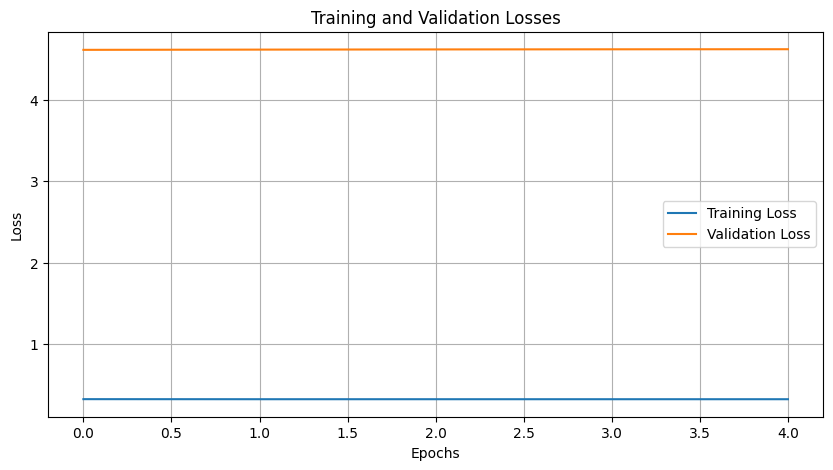

start training for model  5 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 512, 'add_position_features': True, 'dropout': 0.2, 'lr': 0.0001, 'lr_decay': 0.5, 'lr_patience': 3, 'clip': 1.0, 'model_number': 5}
Epoch 1, step:100/553 18.08%, Loss:3.9698, Perplexity:15.6680
Epoch 1, step:200/553 36.17%, Loss:3.8066, Perplexity:13.9927
Epoch 1, step:300/553 54.25%, Loss:3.5991, Perplexity:12.1182
Epoch 1, step:400/553 72.33%, Loss:3.2771, Perplexity:9.6943
Epoch 1, step:500/553 90.42%, Loss:2.8419, Perplexity:7.1694
Epoch 1, validation average loss:3.5184, Perplexity:11.4592
Saving checkpoint to ./best_ckpt5.pt
Saving checkpoint to ./ckpt-1-3.5184.pt
Epoch 2, step:100/553 18.08%, Loss:3.4163, Perplexity:10.6757
Epoch 2, step:200/553 36.17%, Loss:3.1823, Perplexity:9.0777
Epoch 2, step:300/553 54.25%, Loss:2.8762, Perplexity:7.3420
Epoch 2, step:400/553 72.33%, Loss:2.5562, Perplexity:5.8814
Epoch 2, step:500/553 90.42%, Loss:2.4291, Perplexity:5.3855
Epoch 2, validation average loss:3.027

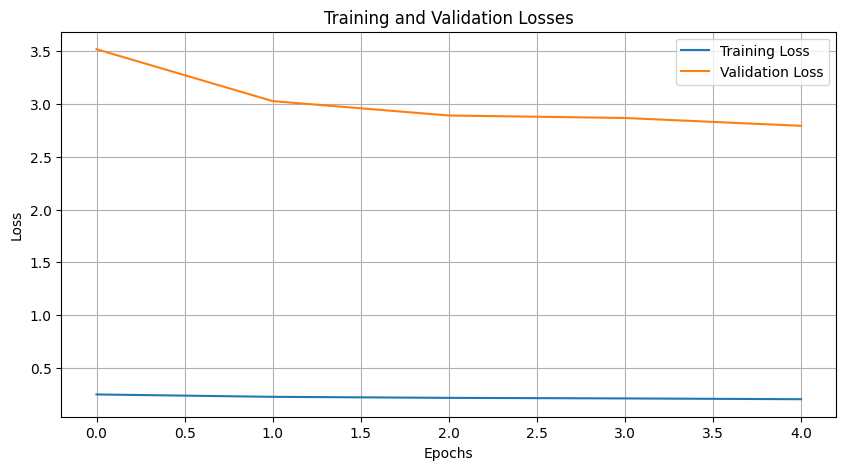

start training for model  6 , hyper-parameters:  {'emb_dim': 100, 'dec_rnn_h': 512, 'add_position_features': True, 'dropout': 0.0, 'lr': 0.0005, 'lr_decay': 0.9, 'lr_patience': 4, 'clip': 3.0, 'model_number': 6}
Epoch 1, step:100/553 18.08%, Loss:3.7339, Perplexity:13.3047
Epoch 1, step:200/553 36.17%, Loss:3.5202, Perplexity:11.4731
Epoch 1, step:300/553 54.25%, Loss:2.9686, Perplexity:7.8275
Epoch 1, step:400/553 72.33%, Loss:2.5234, Perplexity:5.7492
Epoch 1, step:500/553 90.42%, Loss:2.2993, Perplexity:4.9222
Epoch 1, validation average loss:3.1014, Perplexity:8.5823
Saving checkpoint to ./best_ckpt6.pt
Saving checkpoint to ./ckpt-1-3.1014.pt
Epoch 2, step:100/553 18.08%, Loss:3.0546, Perplexity:8.3085
Epoch 2, step:200/553 36.17%, Loss:2.8572, Perplexity:7.2459
Epoch 2, step:300/553 54.25%, Loss:2.5146, Perplexity:5.7143
Epoch 2, step:400/553 72.33%, Loss:2.1552, Perplexity:4.4542
Epoch 2, step:500/553 90.42%, Loss:1.9808, Perplexity:3.9472
Epoch 2, validation average loss:3.0273,

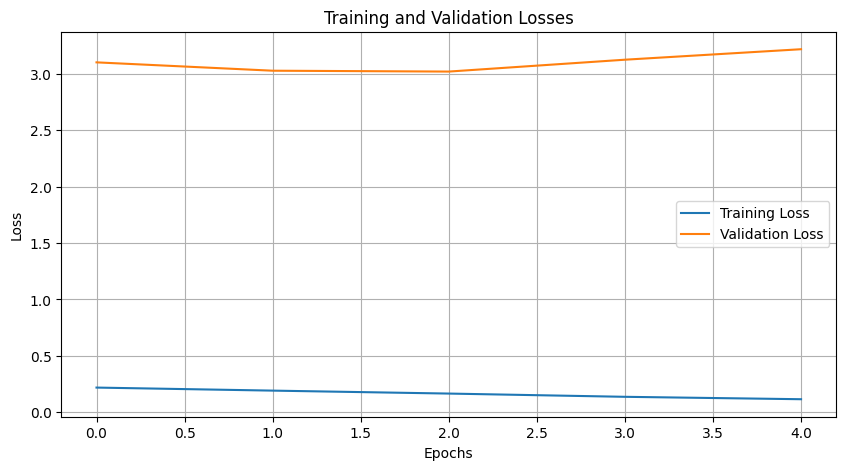

start training for model  7 , hyper-parameters:  {'emb_dim': 50, 'dec_rnn_h': 256, 'add_position_features': True, 'dropout': 0.2, 'lr': 0.0005, 'lr_decay': 0.1, 'lr_patience': 3, 'clip': 1.0, 'model_number': 7}
Epoch 1, step:100/553 18.08%, Loss:4.2076, Perplexity:18.4763
Epoch 1, step:200/553 36.17%, Loss:4.0356, Perplexity:16.3998
Epoch 1, step:300/553 54.25%, Loss:3.8292, Perplexity:14.2141
Epoch 1, step:400/553 72.33%, Loss:3.5779, Perplexity:11.9418
Epoch 1, step:500/553 90.42%, Loss:3.4347, Perplexity:10.8132
Epoch 1, validation average loss:4.0047, Perplexity:16.0520
Saving checkpoint to ./best_ckpt7.pt
Saving checkpoint to ./ckpt-1-4.0047.pt
Epoch 2, step:100/553 18.08%, Loss:4.1282, Perplexity:17.4871
Epoch 2, step:200/553 36.17%, Loss:3.9394, Perplexity:15.3422
Epoch 2, step:300/553 54.25%, Loss:3.7866, Perplexity:13.8000
Epoch 2, step:400/553 72.33%, Loss:3.5533, Perplexity:11.7393
Epoch 2, step:500/553 90.42%, Loss:3.4260, Perplexity:10.7483
Epoch 2, validation average loss

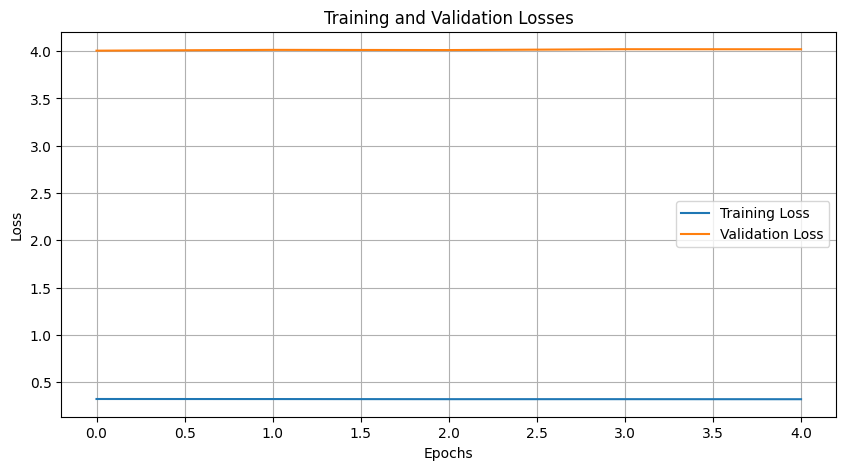

start training for model  8 , hyper-parameters:  {'emb_dim': 100, 'dec_rnn_h': 1024, 'add_position_features': True, 'dropout': 0.2, 'lr': 0.0005, 'lr_decay': 0.9, 'lr_patience': 2, 'clip': 3.0, 'model_number': 8}
Epoch 1, step:100/553 18.08%, Loss:3.7456, Perplexity:13.4136
Epoch 1, step:200/553 36.17%, Loss:3.6355, Perplexity:12.4275
Epoch 1, step:300/553 54.25%, Loss:3.0161, Perplexity:8.0896
Epoch 1, step:400/553 72.33%, Loss:2.6007, Perplexity:6.0657
Epoch 1, step:500/553 90.42%, Loss:2.3728, Perplexity:5.1793
Epoch 1, validation average loss:3.3300, Perplexity:10.0559
Saving checkpoint to ./best_ckpt8.pt
Saving checkpoint to ./ckpt-1-3.3300.pt
Epoch 2, step:100/553 18.08%, Loss:3.1809, Perplexity:9.0690
Epoch 2, step:200/553 36.17%, Loss:2.9980, Perplexity:7.9887
Epoch 2, step:300/553 54.25%, Loss:2.6484, Perplexity:6.2698
Epoch 2, step:400/553 72.33%, Loss:2.2710, Perplexity:4.8266
Epoch 2, step:500/553 90.42%, Loss:2.1032, Perplexity:4.2965
Epoch 2, validation average loss:3.184

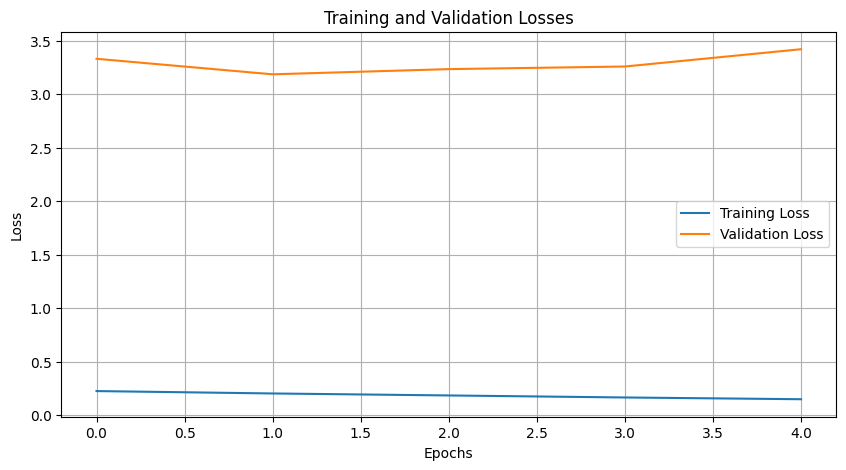

start training for model  9 , hyper-parameters:  {'emb_dim': 50, 'dec_rnn_h': 1024, 'add_position_features': False, 'dropout': 0.0, 'lr': 0.001, 'lr_decay': 0.9, 'lr_patience': 4, 'clip': 3.0, 'model_number': 9}
Epoch 1, step:100/553 18.08%, Loss:3.7712, Perplexity:13.6533
Epoch 1, step:200/553 36.17%, Loss:3.5009, Perplexity:11.3204
Epoch 1, step:300/553 54.25%, Loss:3.0024, Perplexity:8.0133
Epoch 1, step:400/553 72.33%, Loss:2.6157, Perplexity:6.1293
Epoch 1, step:500/553 90.42%, Loss:2.3460, Perplexity:5.0841
Epoch 1, validation average loss:3.1761, Perplexity:9.0389
Saving checkpoint to ./best_ckpt9.pt
Saving checkpoint to ./ckpt-1-3.1761.pt
Epoch 2, step:100/553 18.08%, Loss:3.2513, Perplexity:9.5219
Epoch 2, step:200/553 36.17%, Loss:2.9644, Perplexity:7.8047
Epoch 2, step:300/553 54.25%, Loss:2.6189, Perplexity:6.1429
Epoch 2, step:400/553 72.33%, Loss:2.2325, Perplexity:4.6994
Epoch 2, step:500/553 90.42%, Loss:2.0270, Perplexity:4.0755
Epoch 2, validation average loss:3.0959,

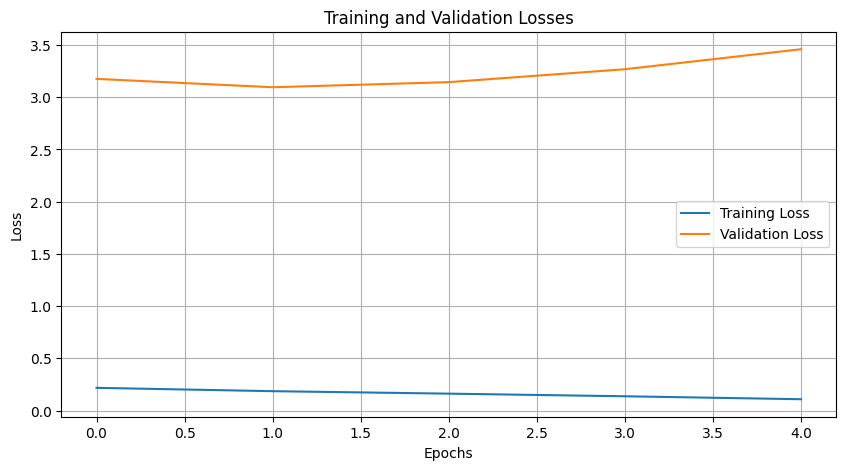

start training for model  10 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 1024, 'add_position_features': True, 'dropout': 0.1, 'lr': 0.001, 'lr_decay': 0.5, 'lr_patience': 2, 'clip': 1.0, 'model_number': 10}
Epoch 1, step:100/553 18.08%, Loss:3.8580, Perplexity:14.5002
Epoch 1, step:200/553 36.17%, Loss:3.7738, Perplexity:13.6778
Epoch 1, step:300/553 54.25%, Loss:3.3724, Perplexity:10.3561
Epoch 1, step:400/553 72.33%, Loss:2.7699, Perplexity:6.8206
Epoch 1, step:500/553 90.42%, Loss:2.5354, Perplexity:5.7972
Epoch 1, validation average loss:3.5215, Perplexity:11.4832
Saving checkpoint to ./best_ckpt10.pt
Saving checkpoint to ./ckpt-1-3.5215.pt
Epoch 2, step:100/553 18.08%, Loss:3.2628, Perplexity:9.5982
Epoch 2, step:200/553 36.17%, Loss:3.2424, Perplexity:9.4639
Epoch 2, step:300/553 54.25%, Loss:2.9074, Perplexity:7.5025
Epoch 2, step:400/553 72.33%, Loss:2.5487, Perplexity:5.8512
Epoch 2, step:500/553 90.42%, Loss:2.4344, Perplexity:5.4054
Epoch 2, validation average loss:3.4

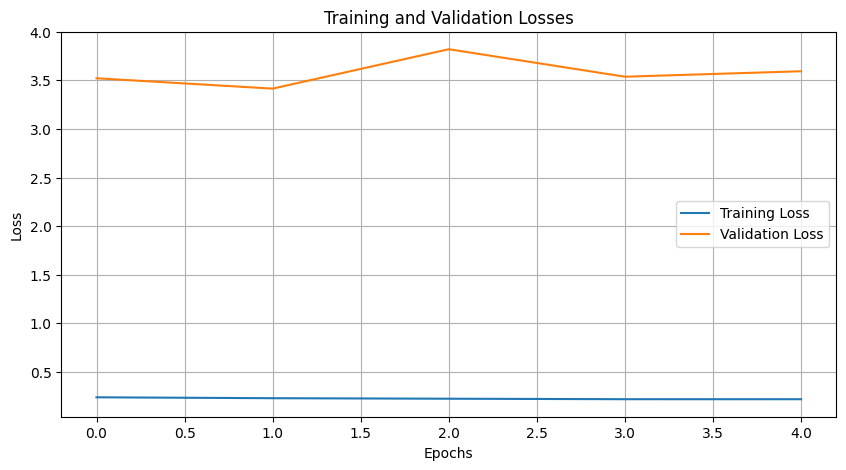

start training for model  11 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 256, 'add_position_features': False, 'dropout': 0.2, 'lr': 0.0005, 'lr_decay': 0.5, 'lr_patience': 2, 'clip': 1.0, 'model_number': 11}
Epoch 1, step:100/553 18.08%, Loss:4.1906, Perplexity:18.2594
Epoch 1, step:200/553 36.17%, Loss:4.0355, Perplexity:16.3986
Epoch 1, step:300/553 54.25%, Loss:3.8510, Perplexity:14.4303
Epoch 1, step:400/553 72.33%, Loss:3.5730, Perplexity:11.9012
Epoch 1, step:500/553 90.42%, Loss:3.4333, Perplexity:10.8027
Epoch 1, validation average loss:4.0069, Perplexity:16.0772
Saving checkpoint to ./best_ckpt11.pt
Saving checkpoint to ./ckpt-1-4.0069.pt
Epoch 2, step:100/553 18.08%, Loss:4.1368, Perplexity:17.5912
Epoch 2, step:200/553 36.17%, Loss:3.9411, Perplexity:15.3598
Epoch 2, step:300/553 54.25%, Loss:3.7973, Perplexity:13.9027
Epoch 2, step:400/553 72.33%, Loss:3.5537, Perplexity:11.7430
Epoch 2, step:500/553 90.42%, Loss:3.4151, Perplexity:10.6668
Epoch 2, validation average 

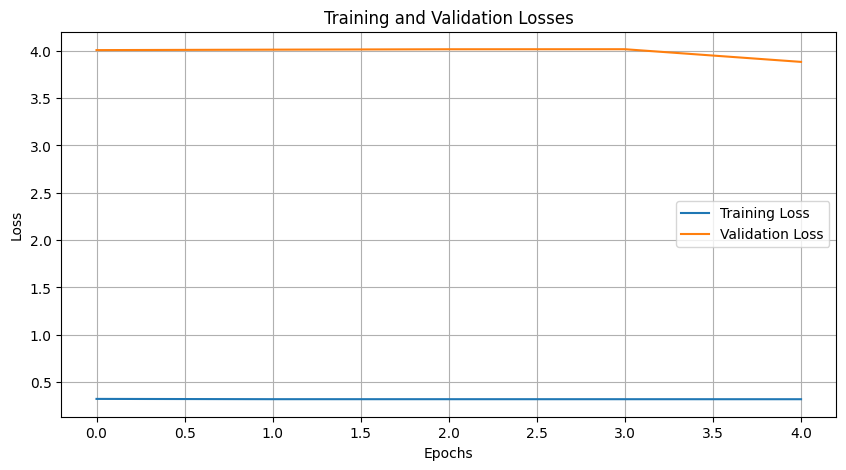

start training for model  12 , hyper-parameters:  {'emb_dim': 100, 'dec_rnn_h': 1024, 'add_position_features': False, 'dropout': 0.1, 'lr': 0.001, 'lr_decay': 0.9, 'lr_patience': 3, 'clip': 2.0, 'model_number': 12}
Epoch 1, step:100/553 18.08%, Loss:3.7100, Perplexity:13.0861
Epoch 1, step:200/553 36.17%, Loss:3.4330, Perplexity:10.8000
Epoch 1, step:300/553 54.25%, Loss:2.9319, Perplexity:7.6312
Epoch 1, step:400/553 72.33%, Loss:2.5159, Perplexity:5.7197
Epoch 1, step:500/553 90.42%, Loss:2.2832, Perplexity:4.8676
Epoch 1, validation average loss:3.1787, Perplexity:9.0550
Saving checkpoint to ./best_ckpt12.pt
Saving checkpoint to ./ckpt-1-3.1787.pt
Epoch 2, step:100/553 18.08%, Loss:3.2457, Perplexity:9.4853
Epoch 2, step:200/553 36.17%, Loss:2.9058, Perplexity:7.4946
Epoch 2, step:300/553 54.25%, Loss:2.5471, Perplexity:5.8447
Epoch 2, step:400/553 72.33%, Loss:2.1624, Perplexity:4.4767
Epoch 2, step:500/553 90.42%, Loss:1.9777, Perplexity:3.9386
Epoch 2, validation average loss:3.3

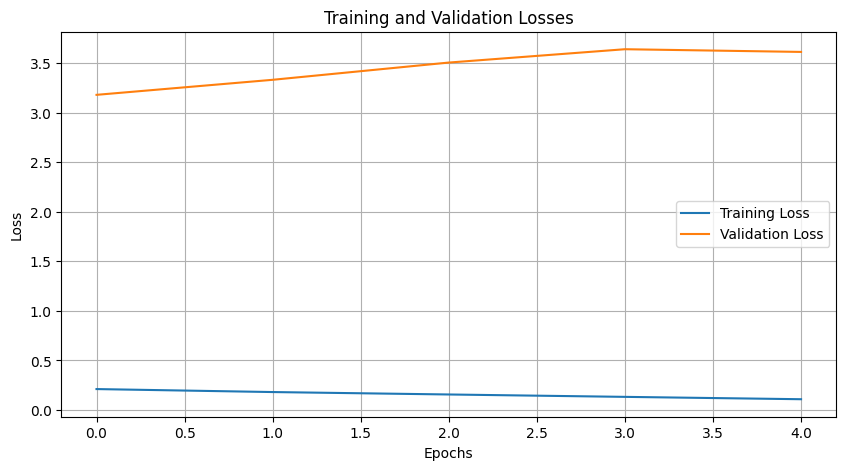

start training for model  13 , hyper-parameters:  {'emb_dim': 50, 'dec_rnn_h': 512, 'add_position_features': False, 'dropout': 0.2, 'lr': 0.001, 'lr_decay': 0.1, 'lr_patience': 3, 'clip': 1.0, 'model_number': 13}
Epoch 1, step:100/553 18.08%, Loss:4.6103, Perplexity:24.4246
Epoch 1, step:200/553 36.17%, Loss:4.2826, Perplexity:19.4616
Epoch 1, step:300/553 54.25%, Loss:4.0608, Perplexity:16.6893
Epoch 1, step:400/553 72.33%, Loss:3.7249, Perplexity:13.2220
Epoch 1, step:500/553 90.42%, Loss:3.5747, Perplexity:11.9145
Epoch 1, validation average loss:4.5347, Perplexity:23.1778
Saving checkpoint to ./best_ckpt13.pt
Saving checkpoint to ./ckpt-1-4.5347.pt
Epoch 2, step:100/553 18.08%, Loss:4.4397, Perplexity:21.7009
Epoch 2, step:200/553 36.17%, Loss:4.1892, Perplexity:18.2418
Epoch 2, step:300/553 54.25%, Loss:4.0069, Perplexity:16.0772
Epoch 2, step:400/553 72.33%, Loss:3.7141, Perplexity:13.1233
Epoch 2, step:500/553 90.42%, Loss:3.5620, Perplexity:11.8108
Epoch 2, validation average l

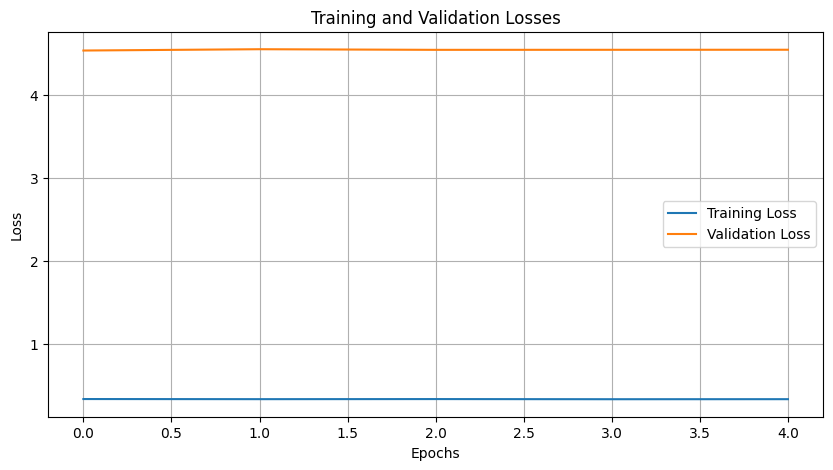

start training for model  14 , hyper-parameters:  {'emb_dim': 80, 'dec_rnn_h': 1024, 'add_position_features': True, 'dropout': 0.1, 'lr': 0.0001, 'lr_decay': 0.5, 'lr_patience': 3, 'clip': 3.0, 'model_number': 14}
Epoch 1, step:100/553 18.08%, Loss:3.8003, Perplexity:13.9313
Epoch 1, step:200/553 36.17%, Loss:3.7234, Perplexity:13.2087
Epoch 1, step:300/553 54.25%, Loss:3.4402, Perplexity:10.8543
Epoch 1, step:400/553 72.33%, Loss:2.7989, Perplexity:6.9589
Epoch 1, step:500/553 90.42%, Loss:2.5312, Perplexity:5.7803
Epoch 1, validation average loss:3.2109, Perplexity:9.2594
Saving checkpoint to ./best_ckpt14.pt
Saving checkpoint to ./ckpt-1-3.2109.pt
Epoch 2, step:100/553 18.08%, Loss:3.1337, Perplexity:8.7767
Epoch 2, step:200/553 36.17%, Loss:3.0478, Perplexity:8.2695
Epoch 2, step:300/553 54.25%, Loss:2.7068, Perplexity:6.5287
Epoch 2, step:400/553 72.33%, Loss:2.3769, Perplexity:5.1943
Epoch 2, step:500/553 90.42%, Loss:2.2687, Perplexity:4.8190
Epoch 2, validation average loss:3.0

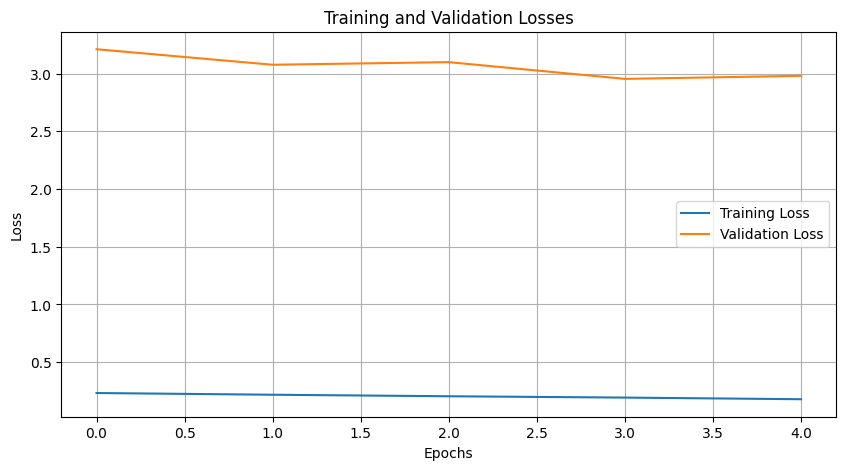

In [57]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from functools import partial

def main(num_search_rounds):
    # Configuration settings
    config = {
        # model configs
        "emb_dim": 80,
        "dec_rnn_h": 512,
        "data_path": "./",
        "add_position_features": False,
        # training configs
        "max_len": 150,
        "dropout": 0.0,
        "cuda": True,
        "batch_size": 16,
        "epochs": 5,
        "lr": 3e-4,
        "min_lr": 3e-5,
        "sample_method": "teacher_forcing",  # schedule sampling method, choices=('teacher_forcing', 'exp', 'inv_sigmoid')
        "decay_k": 1.0,  # decay constant for sampling, or a constant in inverse sigmoid decay equation https://arxiv.org/pdf/1506.03099.pdf
        "lr_decay": 0.5,
        "lr_patience": 3,
        "clip": 2.0,
        "save_dir": "./",
        "print_freq": 100,
        "seed": 2020,
        "from_check_point": False # training from checkpoint or not
    }

    torch.manual_seed(config["seed"])
    if config["cuda"]:
        torch.cuda.manual_seed(config["seed"])

    # Load vocabulary
    vocab = load_vocab(config["data_path"])
    device = torch.device("cuda" if config["cuda"] and torch.cuda.is_available() else "cpu")

    # Data loader setup
    train_loader = DataLoader(
        Im2LatexDataset(config["data_path"], 'train', config["max_len"]),
        batch_size=config["batch_size"],
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=config["cuda"],
        num_workers=4
    )
    val_loader = DataLoader(
        Im2LatexDataset(config["data_path"], 'test', config["max_len"]),
        batch_size=config["batch_size"],
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=config["cuda"],
        num_workers=4
    )

    vocab_size = len(vocab)

    results = []
    for i in range(num_search_rounds):

        # Sample hyperparameters
        sampled_hyperparameters = {param: random.choice(values) for param, values in search_space.items()}
        sampled_hyperparameters["model_number"] = i
        print("start training for model ",i,", hyper-parameters: ",sampled_hyperparameters)

        # Update configuration with sampled hyperparameters
        config.update(sampled_hyperparameters)

        # Model, Optimizer, and Scheduler
        model = Im2LatexModel(
            vocab_size, sampled_hyperparameters["emb_dim"], sampled_hyperparameters["dec_rnn_h"],
            add_pos_feat=sampled_hyperparameters["add_position_features"],
            dropout=sampled_hyperparameters["dropout"]
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=sampled_hyperparameters["lr"])
        lr_scheduler = ReduceLROnPlateau(
            optimizer, "min", factor=sampled_hyperparameters["lr_decay"],
            patience=sampled_hyperparameters["lr_patience"], verbose=True, min_lr=config["min_lr"])

        # Initialize or load from checkpoint
        # Start training, for the ith config
        trainer = Trainer(optimizer, model, lr_scheduler, train_loader, val_loader, config, use_cuda=config["cuda"], init_epoch=1, last_epoch=config["epochs"])
        if config["from_check_point"]:
            checkpoint = get_checkpoint(config["save_dir"])
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
            trainer.init_epoch = checkpoint['epoch'] + 1

        train_loss, val_loss = trainer.train()

        # Record results
        result = {
            "model tag": i,
            "hyperparameters": sampled_hyperparameters,
            "train_loss": train_loss,
            "val_loss": val_loss
        }
        results.append(result)

    return results

if __name__ == "__main__":
    num_search_rounds = 15
    search_results = main(num_search_rounds)


In [ ]:
search_results

[{'model tag': 0,
  'hyperparameters': {'emb_dim': 75,
   'dec_rnn_h': 256,
   'add_position_features': True,
   'dropout': 0.0,
   'lr': 0.01,
   'decay_k': 1.0,
   'lr_decay': 0.1,
   'lr_patience': 2,
   'clip': 2.0,
   'model_number': 0},
  'train_loss': [1.2520164978633288,
   1.218823339104222,
   1.2112685205273679,
   1.214899177585698,
   0.9768944828088533,
   0.9633494998573826,
   0.961521393125238,
   0.9610348160946842,
   0.9610708827146124,
   0.9610616050472328],
  'val_loss': [5.311248302459717,
   5.480017185211182,
   5.3523125648498535,
   5.468563556671143,
   4.18639612197876,
   4.1243462562561035,
   4.107458114624023,
   4.109669208526611,
   4.111155033111572,
   4.112540245056152]},
 {'model tag': 1,
  'hyperparameters': {'emb_dim': 50,
   'dec_rnn_h': 1024,
   'add_position_features': False,
   'dropout': 0.1,
   'lr': 0.01,
   'decay_k': 0.5,
   'lr_decay': 0.1,
   'lr_patience': 3,
   'clip': 3.0,
   'model_number': 1},
  'train_loss': [nan, nan, nan, nan

##Plotting the train and val loss for all models

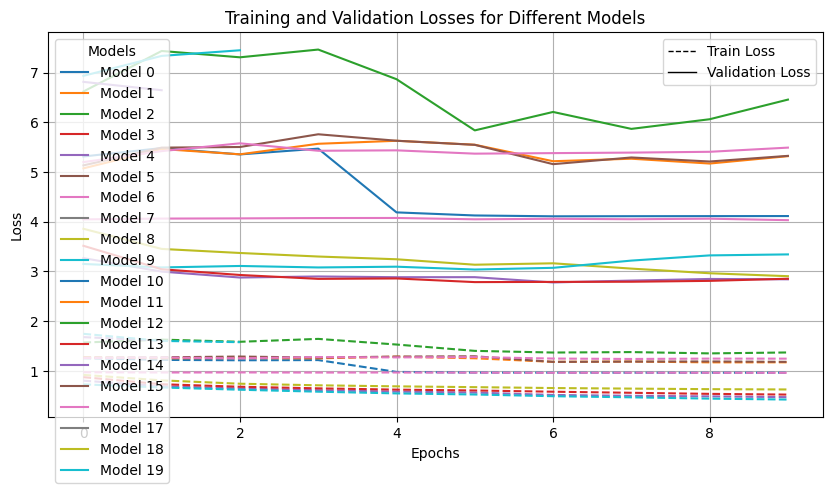

In [ ]:
import matplotlib.pyplot as plt

def plot_results(results):
    plt.figure(figsize=(10, 5))

    # Get a color cycle to use distinct colors for each model automatically
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Create custom handles for the line style legend
    train_line = plt.Line2D([0], [0], color='black', linewidth=1, linestyle='--', label='Train Loss')
    val_line = plt.Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Validation Loss')

    # Plotting data and preparing model color legend
    for idx, result in enumerate(results):
        model_tag = result["model tag"]
        train_loss = result["train_loss"]
        val_loss = result["val_loss"]

        # Use the same color for train and val loss of the same model
        color = colors[idx % len(colors)]

        # Plot training and validation losses
        plt.plot(train_loss, linestyle='--', color=color)
        plt.plot(val_loss, linestyle='-', color=color)

        # Add model legend entry
        plt.plot([], [], color=color, label=f'Model {model_tag}')  # Empty plot for color legend

    # Set titles and labels
    plt.title('Training and Validation Losses for Different Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Create legends
    # First legend for the losses with custom line style legend
    first_legend = plt.legend(handles=[train_line, val_line], loc='upper right')
    plt.gca().add_artist(first_legend)
    # Second legend for the models with color coding
    plt.legend(title="Models", loc='upper left')

    plt.grid(True)
    plt.show()

plot_results(search_results)


##Finding the Best Model

In [ ]:
def find_best_model(results):
    # Initialize variables to keep track of the best model
    min_loss = float('inf')
    best_model_hyperparameters = None

    # Iterate through all models in the results
    for result in results:
        # Calculate the average validation loss for the current model
        val_losses = result["val_loss"]
        # Filter out non-numeric entries to safely compute the mean
        numeric_losses = [loss for loss in val_losses if isinstance(loss, (int, float))]
        if numeric_losses:  # Ensure there is at least one numeric loss to avoid division by zero
            avg_loss = sum(numeric_losses) / len(numeric_losses)
            # Check if the current model's average validation loss is the lowest found so far
            if avg_loss < min_loss:
                min_loss = avg_loss
                best_model_hyperparameters = result["hyperparameters"]

    # Check if a best model was found
    if best_model_hyperparameters is not None:
        print("Best Model Hyperparameters:")
        for param, value in best_model_hyperparameters.items():
            print(f"{param}: {value}")
    else:
        print("No valid model results found.")

find_best_model(search_results)


Best Model Hyperparameters:
emb_dim: 100
dec_rnn_h: 1024
add_position_features: True
dropout: 0.1
lr: 0.0001
decay_k: 1.0
lr_decay: 0.4
lr_patience: 2
clip: 2.0
model_number: 4


## Plotting the effect of specific hyper-parameters on the best validation accuracy

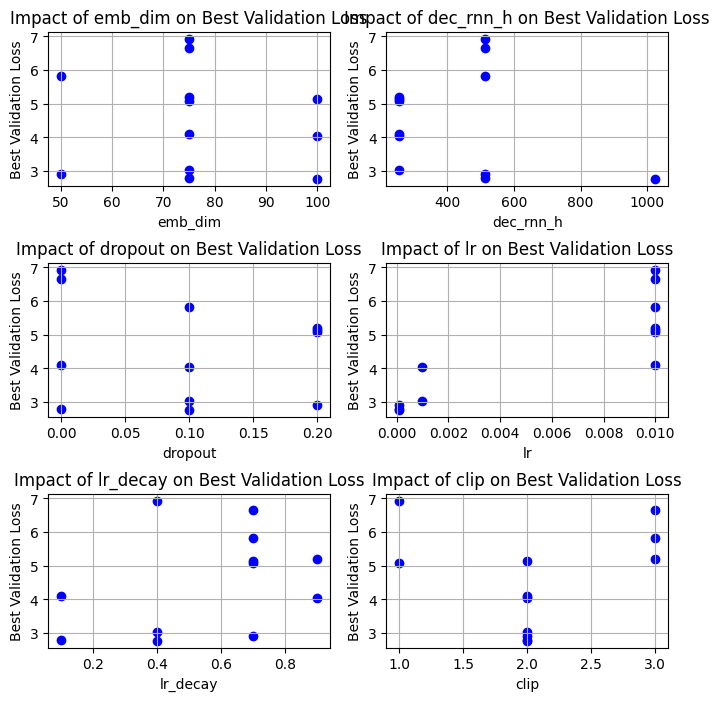

In [ ]:
# Organizing data for plotting
hyperparameters = ['emb_dim', 'dec_rnn_h', 'dropout', 'lr', 'lr_decay', 'clip']
hp_values = {hp: [] for hp in hyperparameters}
val_losses = []

for item in search_results:
    best_val_loss = min(item['val_loss'])
    val_losses.append(best_val_loss)
    for hp in hyperparameters:
        hp_values[hp].append(item['hyperparameters'][hp])

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, hp in enumerate(hyperparameters):
    if i < len(axes):  # To prevent index errors if there are more hyperparameters than subplots
        axes[i].scatter(hp_values[hp], val_losses, color='blue')
        axes[i].set_title(f'Impact of {hp} on Best Validation Loss')
        axes[i].set_xlabel(hp)
        axes[i].set_ylabel('Best Validation Loss')
        axes[i].grid(True)

plt.show()

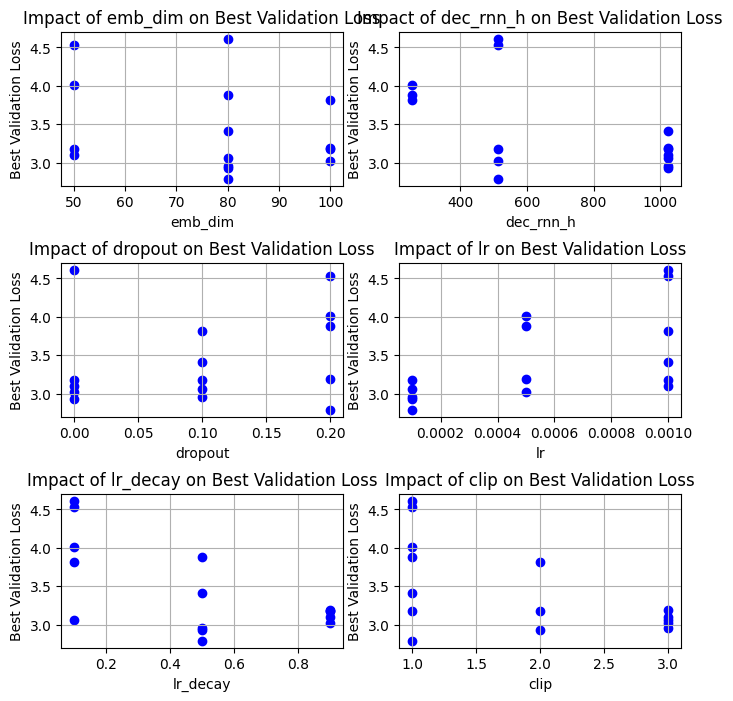

In [61]:
# Organizing data for plotting
hyperparameters = ['emb_dim', 'dec_rnn_h', 'dropout', 'lr', 'lr_decay', 'clip']
hp_values = {hp: [] for hp in hyperparameters}
val_losses = []

for item in search_results:
    best_val_loss = min(item['val_loss'])
    val_losses.append(best_val_loss)
    for hp in hyperparameters:
        hp_values[hp].append(item['hyperparameters'][hp])

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, hp in enumerate(hyperparameters):
    if i < len(axes):  # To prevent index errors if there are more hyperparameters than subplots
        axes[i].scatter(hp_values[hp], val_losses, color='blue')
        axes[i].set_title(f'Impact of {hp} on Best Validation Loss')
        axes[i].set_xlabel(hp)
        axes[i].set_ylabel('Best Validation Loss')
        axes[i].grid(True)

plt.show()

##evaluate the model

In [ ]:
from os.path import join
from functools import partial
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def main():
    # Configuration settings
    config = {
        "model_path": "./best_ckpt0.pt",  # Path to the trained model checkpoint
        "data_path": "./",  # Path to the dataset directory
        "cuda": True,  # Flag to use CUDA if available
        "batch_size": 32,  # Batch size for evaluation
        "beam_size": 3,  # Beam size for the beam search in the LatexProducer
        "result_path": "./result.txt",  # Path to store the generated results
        "ref_path": "./ref.txt",  # Path to store the references
        "max_len": 64,  # Maximum decoding steps
        "split": "test"  # Data split to use for evaluation
    }

    # Load the model checkpoint
    checkpoint = torch.load(config["model_path"], map_location=torch.device('cpu'))
    model_args = checkpoint['args']  # These are the args saved with the model

    # Load the vocabulary
    vocab = load_vocab(config["data_path"])
    use_cuda = config["cuda"] and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Initialize the data loader for the evaluation dataset
    data_loader = DataLoader(
        Im2LatexDataset(config["data_path"], config["split"], config["max_len"]),
        batch_size=config["batch_size"],
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=use_cuda,
        num_workers=4
    )

    # Initialize the model
    model = Im2LatexModel(
        len(vocab), model_args['emb_dim'], model_args['dec_rnn_h'],
        add_pos_feat=model_args['add_position_features'],
        dropout=model_args['dropout']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Open result files
    result_file = open(config["result_path"], 'w')
    ref_file = open(config["ref_path"], 'w')

    # Latex generation process
    latex_producer = LatexProducer(
        model, vocab, max_len=config["max_len"],
        use_cuda=use_cuda, beam_size=config["beam_size"]
    )

    # Evaluate each batch and write the results
    for imgs, tgt4training, tgt4cal_loss in tqdm(data_loader):
        imgs = imgs.to(device)
        try:
            reference = latex_producer._idx2formulas(tgt4cal_loss)
            results = latex_producer(imgs)
        except RuntimeError as e:
            print("Runtime error:", e)
            break

        result_file.write('\n'.join(results) + '\n')
        ref_file.write('\n'.join(reference) + '\n')

    # Close files and score the results
    result_file.close()
    ref_file.close()
    score = score_files(config["result_path"], config["ref_path"])
    print("Beam search result:", score)

if __name__ == "__main__":
    main()


Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.45it/s]

Loaded 32 formulas from ./result.txt
Loaded 32 formulas from ./ref.txt
Beam search result: {'BLEU-4': 6.65992296574857, 'EM': 0.0, 'Edit': 19.38073394495413, 'Partial Match': 42.61363636363637}


##Eval for hyper-parameters tunings and grid searching beam size

In [62]:
from os.path import join
from functools import partial
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

def evaluate_model(config):
    # Start timing
    start_time = time.time()

    # Load the model checkpoint
    try:
        checkpoint_path = join('./', f'best_ckpt{config["model_number"]}.pt')
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    except FileNotFoundError:
        print(f"Checkpoint file not found for model {config['model_number']}. Skipping...")
        return None, None  # Return None to indicate skipped evaluation
    model_args = checkpoint['args']  # These are the args saved with the model

    # Load the vocabulary
    vocab = load_vocab(config["data_path"])
    use_cuda = config["cuda"] and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Initialize the data loader for the evaluation dataset
    data_loader = DataLoader(
        Im2LatexDataset(config["data_path"], config["split"], config["max_len"]),
        batch_size=config["batch_size"],
        collate_fn=partial(collate_fn, vocab.sign2id),
        pin_memory=use_cuda,
        num_workers=4
    )

    # Initialize the model
    model = Im2LatexModel(
        len(vocab), model_args['emb_dim'], model_args['dec_rnn_h'],
        add_pos_feat=model_args['add_position_features'],
        dropout=model_args['dropout']
    ).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Open result files
    result_file = open(config["result_path"], 'w')
    ref_file = open(config["ref_path"], 'w')

    # Latex generation process
    latex_producer = LatexProducer(
        model, vocab, max_len=config["max_len"],
        use_cuda=use_cuda, beam_size=config["beam_size"]
    )

    # Evaluate each batch and write the results
    for imgs, tgt4training, tgt4cal_loss in tqdm(data_loader):
        imgs = imgs.to(device)
        try:
            reference = latex_producer._idx2formulas(tgt4cal_loss)
            results = latex_producer(imgs)
        except RuntimeError as e:
            print("Runtime error:", e)
            break

        result_file.write('\n'.join(results) + '\n')
        ref_file.write('\n'.join(reference) + '\n')

    # Close files and score the results
    result_file.close()
    ref_file.close()
    score = score_files(config["result_path"], config["ref_path"])

    # End timing
    end_time = time.time()
    evaluation_time = end_time - start_time

    return score, evaluation_time

def main():
    results = []
    for model_number in range(0, 15):
        for beam_size in [1, 3, 5,10]:
            config = {
                "model_number": model_number,
                "data_path": "./",  # Path to the dataset directory
                "cuda": True,  # Flag to use CUDA if available
                "batch_size": 32,  # Batch size for evaluation
                "beam_size": beam_size,  # Beam size for the beam search in the LatexProducer
                "result_path": f"./result_model_{model_number}_beam_{beam_size}.txt",  # Path to store the generated results
                "ref_path": f"./ref_model_{model_number}_beam_{beam_size}.txt",  # Path to store the references
                "max_len": 64,  # Maximum decoding steps
                "split": "test"  # Data split to use for evaluation
            }

            score, evaluation_time = evaluate_model(config)
            results.append({"config": config, "score": score, "time": evaluation_time})
    return results

if __name__ == "__main__":
    results = main()


Load vocab including 113 words!


  0%|          | 0/31 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 31/31 [00:02<00:00, 12.76it/s]


Loaded 32 formulas from ./result_model_0_beam_1.txt
Loaded 32 formulas from ./ref_model_0_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 16.14it/s]


Loaded 32 formulas from ./result_model_0_beam_3.txt
Loaded 32 formulas from ./ref_model_0_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 15.65it/s]


Loaded 32 formulas from ./result_model_0_beam_5.txt
Loaded 32 formulas from ./ref_model_0_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 10.35it/s]


Loaded 32 formulas from ./result_model_0_beam_10.txt
Loaded 32 formulas from ./ref_model_0_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.89it/s]


Loaded 32 formulas from ./result_model_1_beam_1.txt
Loaded 32 formulas from ./ref_model_1_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 11.39it/s]


Loaded 32 formulas from ./result_model_1_beam_3.txt
Loaded 32 formulas from ./ref_model_1_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 10.84it/s]


Loaded 32 formulas from ./result_model_1_beam_5.txt
Loaded 32 formulas from ./ref_model_1_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.94it/s]


Loaded 32 formulas from ./result_model_1_beam_10.txt
Loaded 32 formulas from ./ref_model_1_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.85it/s]


Loaded 32 formulas from ./result_model_2_beam_1.txt
Loaded 32 formulas from ./ref_model_2_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 16.83it/s]


Loaded 32 formulas from ./result_model_2_beam_3.txt
Loaded 32 formulas from ./ref_model_2_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 15.05it/s]


Loaded 32 formulas from ./result_model_2_beam_5.txt
Loaded 32 formulas from ./ref_model_2_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 14.99it/s]


Loaded 32 formulas from ./result_model_2_beam_10.txt
Loaded 32 formulas from ./ref_model_2_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.72it/s]
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Loaded 32 formulas from ./result_model_3_beam_1.txt
Loaded 32 formulas from ./ref_model_3_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.50it/s]


Loaded 32 formulas from ./result_model_3_beam_3.txt
Loaded 32 formulas from ./ref_model_3_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.40it/s]


Loaded 32 formulas from ./result_model_3_beam_5.txt
Loaded 32 formulas from ./ref_model_3_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  8.99it/s]


Loaded 32 formulas from ./result_model_3_beam_10.txt
Loaded 32 formulas from ./ref_model_3_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.45it/s]


Loaded 32 formulas from ./result_model_4_beam_1.txt
Loaded 32 formulas from ./ref_model_4_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.44it/s]


Loaded 32 formulas from ./result_model_4_beam_3.txt
Loaded 32 formulas from ./ref_model_4_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.25it/s]


Loaded 32 formulas from ./result_model_4_beam_5.txt
Loaded 32 formulas from ./ref_model_4_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  8.83it/s]


Loaded 32 formulas from ./result_model_4_beam_10.txt
Loaded 32 formulas from ./ref_model_4_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.75it/s]


Loaded 32 formulas from ./result_model_5_beam_1.txt
Loaded 32 formulas from ./ref_model_5_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00, 10.23it/s]


Loaded 32 formulas from ./result_model_5_beam_3.txt
Loaded 32 formulas from ./ref_model_5_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 10.35it/s]


Loaded 32 formulas from ./result_model_5_beam_5.txt
Loaded 32 formulas from ./ref_model_5_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.60it/s]


Loaded 32 formulas from ./result_model_5_beam_10.txt
Loaded 32 formulas from ./ref_model_5_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.42it/s]


Loaded 32 formulas from ./result_model_6_beam_1.txt
Loaded 32 formulas from ./ref_model_6_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 20.97it/s]


Loaded 32 formulas from ./result_model_6_beam_3.txt
Loaded 32 formulas from ./ref_model_6_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 20.59it/s]


Loaded 32 formulas from ./result_model_6_beam_5.txt
Loaded 32 formulas from ./ref_model_6_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 19.72it/s]


Loaded 32 formulas from ./result_model_6_beam_10.txt
Loaded 32 formulas from ./ref_model_6_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.54it/s]
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Loaded 32 formulas from ./result_model_7_beam_1.txt
Loaded 32 formulas from ./ref_model_7_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.25it/s]


Loaded 32 formulas from ./result_model_7_beam_3.txt
Loaded 32 formulas from ./ref_model_7_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.47it/s]


Loaded 32 formulas from ./result_model_7_beam_5.txt
Loaded 32 formulas from ./ref_model_7_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  8.98it/s]


Loaded 32 formulas from ./result_model_7_beam_10.txt
Loaded 32 formulas from ./ref_model_7_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.70it/s]


Loaded 32 formulas from ./result_model_8_beam_1.txt
Loaded 32 formulas from ./ref_model_8_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 16.44it/s]


Loaded 32 formulas from ./result_model_8_beam_3.txt
Loaded 32 formulas from ./ref_model_8_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 16.26it/s]


Loaded 32 formulas from ./result_model_8_beam_5.txt
Loaded 32 formulas from ./ref_model_8_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.69it/s]


Loaded 32 formulas from ./result_model_8_beam_10.txt
Loaded 32 formulas from ./ref_model_8_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.66it/s]


Loaded 32 formulas from ./result_model_9_beam_1.txt
Loaded 32 formulas from ./ref_model_9_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.43it/s]


Loaded 32 formulas from ./result_model_9_beam_3.txt
Loaded 32 formulas from ./ref_model_9_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.20it/s]


Loaded 32 formulas from ./result_model_9_beam_5.txt
Loaded 32 formulas from ./ref_model_9_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.00it/s]


Loaded 32 formulas from ./result_model_9_beam_10.txt
Loaded 32 formulas from ./ref_model_9_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.97it/s]


Loaded 32 formulas from ./result_model_10_beam_1.txt
Loaded 32 formulas from ./ref_model_10_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 22.08it/s]


Loaded 32 formulas from ./result_model_10_beam_3.txt
Loaded 32 formulas from ./ref_model_10_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 21.24it/s]


Loaded 32 formulas from ./result_model_10_beam_5.txt
Loaded 32 formulas from ./ref_model_10_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:01<00:00, 19.81it/s]


Loaded 32 formulas from ./result_model_10_beam_10.txt
Loaded 32 formulas from ./ref_model_10_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.90it/s]


Loaded 32 formulas from ./result_model_11_beam_1.txt
Loaded 32 formulas from ./ref_model_11_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.48it/s]


Loaded 32 formulas from ./result_model_11_beam_3.txt
Loaded 32 formulas from ./ref_model_11_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.31it/s]


Loaded 32 formulas from ./result_model_11_beam_5.txt
Loaded 32 formulas from ./ref_model_11_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.04it/s]


Loaded 32 formulas from ./result_model_11_beam_10.txt
Loaded 32 formulas from ./ref_model_11_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.96it/s]


Loaded 32 formulas from ./result_model_12_beam_1.txt
Loaded 32 formulas from ./ref_model_12_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.35it/s]


Loaded 32 formulas from ./result_model_12_beam_3.txt
Loaded 32 formulas from ./ref_model_12_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.33it/s]


Loaded 32 formulas from ./result_model_12_beam_5.txt
Loaded 32 formulas from ./ref_model_12_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  8.99it/s]


Loaded 32 formulas from ./result_model_12_beam_10.txt
Loaded 32 formulas from ./ref_model_12_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.69it/s]


Loaded 32 formulas from ./result_model_13_beam_1.txt
Loaded 32 formulas from ./ref_model_13_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.56it/s]


Loaded 32 formulas from ./result_model_13_beam_3.txt
Loaded 32 formulas from ./ref_model_13_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.28it/s]


Loaded 32 formulas from ./result_model_13_beam_5.txt
Loaded 32 formulas from ./ref_model_13_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00,  9.07it/s]


Loaded 32 formulas from ./result_model_13_beam_10.txt
Loaded 32 formulas from ./ref_model_13_beam_10.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 13.93it/s]


Loaded 32 formulas from ./result_model_14_beam_1.txt
Loaded 32 formulas from ./ref_model_14_beam_1.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 11.20it/s]


Loaded 32 formulas from ./result_model_14_beam_3.txt
Loaded 32 formulas from ./ref_model_14_beam_3.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:02<00:00, 10.54it/s]


Loaded 32 formulas from ./result_model_14_beam_5.txt
Loaded 32 formulas from ./ref_model_14_beam_5.txt
Load vocab including 113 words!


100%|██████████| 31/31 [00:03<00:00, 10.00it/s]

Loaded 32 formulas from ./result_model_14_beam_10.txt
Loaded 32 formulas from ./ref_model_14_beam_10.txt


In [75]:
results

[{'config': {'model_number': 0,
   'data_path': './',
   'cuda': True,
   'batch_size': 32,
   'beam_size': 1,
   'result_path': './result_model_0_beam_1.txt',
   'ref_path': './ref_model_0_beam_1.txt',
   'max_len': 64,
   'split': 'test'},
  'score': {'BLEU-4': 8.413372039782178,
   'EM': 0.0,
   'Edit': 20.626631853785902,
   'Partial Match': 80.56818181818181},
  'time': 2.8999733924865723},
 {'config': {'model_number': 0,
   'data_path': './',
   'cuda': True,
   'batch_size': 32,
   'beam_size': 3,
   'result_path': './result_model_0_beam_3.txt',
   'ref_path': './ref_model_0_beam_3.txt',
   'max_len': 64,
   'split': 'test'},
  'score': {'BLEU-4': 6.980196959416804,
   'EM': 0.0,
   'Edit': 24.5,
   'Partial Match': 77.72727272727272},
  'time': 2.4230620861053467},
 {'config': {'model_number': 0,
   'data_path': './',
   'cuda': True,
   'batch_size': 32,
   'beam_size': 5,
   'result_path': './result_model_0_beam_5.txt',
   'ref_path': './ref_model_0_beam_5.txt',
   'max_len':

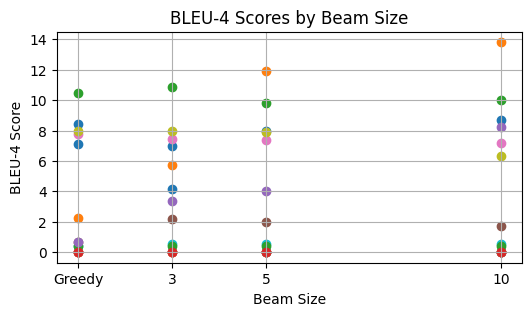

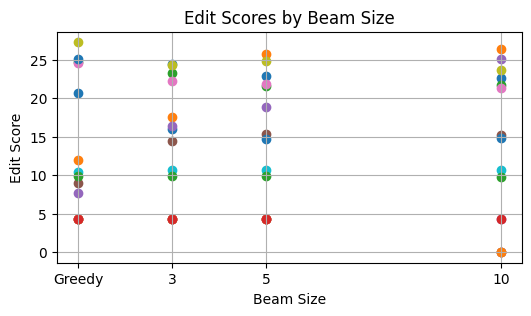

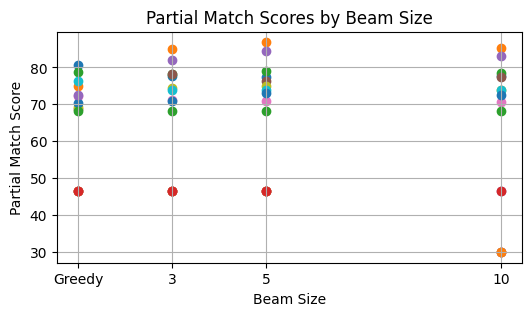

In [68]:
# Prepare data for plotting
models = range(15)  # Model numbers from 0 to 5
beam_sizes = [1, 3, 5, 10]  # Beam sizes
metrics = ['BLEU-4', 'Edit', 'Partial Match']

# Initialize figure


# Creating a plot for each metric
for metric in metrics:
    fig, ax = plt.subplots(figsize=(6, 3))
    for model in models:
        # Gather scores for this model across all beam sizes
        scores = [next(item['score'][metric] for item in results if item['config']['model_number'] == model and item['config']['beam_size'] == beam_size) for beam_size in beam_sizes]
        # Plot these scores against the beam sizes
        ax.scatter(beam_sizes, scores, marker='o')

    # Setting beam size 1 to 'Greedy' in the x-axis labels
    ax.set_xticks(beam_sizes)
    ax.set_xticklabels(['Greedy' if x == 1 else str(x) for x in beam_sizes])

    ax.set_title(f'{metric} Scores by Beam Size')
    ax.set_xlabel('Beam Size')
    ax.set_ylabel(f'{metric} Score')
    ax.grid(True)
    plt.show()


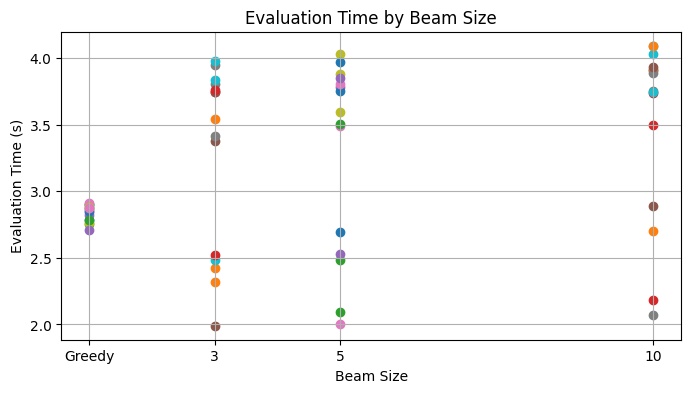

In [74]:
fig, ax = plt.subplots(figsize=(8, 4))
for result in results:
    model_number = result['config']['model_number']
    beam_size = result['config']['beam_size']
    time = result['time']
    plt.scatter(beam_size, time)
ax.set_xticks(beam_sizes)
ax.set_xticklabels(['Greedy' if x == 1 else str(x) for x in beam_sizes])
plt.title('Evaluation Time by Beam Size')
plt.xlabel('Beam Size')
plt.ylabel('Evaluation Time (s)')
plt.grid(True)
plt.show()

## The accuracy of the best model

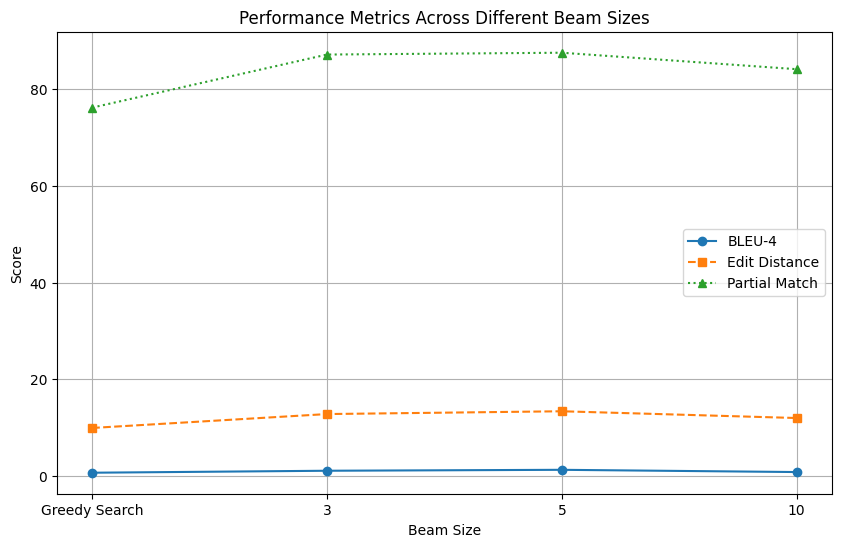

In [ ]:
import matplotlib.pyplot as plt

# Define the beam sizes and corresponding labels
beam_sizes = [result['config']['beam_size'] for result in results]
beam_labels = ['Greedy Search' if size == 1 else str(size) for size in beam_sizes]

# Extracting scores
bleu_scores = [result['score']['BLEU-4'] for result in results]
edit_distances = [result['score']['Edit'] for result in results]
partial_matches = [result['score']['Partial Match'] for result in results]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(beam_labels, bleu_scores, label='BLEU-4', marker='o', linestyle='-')
plt.plot(beam_labels, edit_distances, label='Edit Distance', marker='s', linestyle='--')
plt.plot(beam_labels, partial_matches, label='Partial Match', marker='^', linestyle=':')

# Adding titles and labels
plt.title('Performance Metrics Across Different Beam Sizes')
plt.xlabel('Beam Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
